In [264]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [214]:
# import datasets

sensorA_System1 = pd.read_csv("/Users/jessie_w/MDS/Capstone/RawData/System1_SensorA.csv")
sensorA_System2 = pd.read_csv("/Users/jessie_w/MDS/Capstone/RawData/System2_SensorA.csv")
sensorB_System1 = pd.read_csv("/Users/jessie_w/MDS/Capstone/RawData/System1_SensorB.csv")
sensorB_System2 = pd.read_csv("/Users/jessie_w/MDS/Capstone/RawData/System2_SensorB.csv")
keyByTestID = pd.read_csv("/Users/jessie_w/MDS/Capstone/RawData/Key by TestID.csv")

In [215]:
# Transpose dataset to make columns as timestamps and rows as tests
A1_transposed = sensorA_System1.T.reset_index()
A1_transposed.columns = A1_transposed.iloc[0]
A1_transposed.rename(columns={A1_transposed.columns[0]: 'TestID'}, inplace=True)
A1_transposed = A1_transposed.drop(0)
A1_transposed['TestID'] = A1_transposed['TestID'].astype(int)

A2_transposed = sensorA_System2.T.reset_index()
A2_transposed.columns = A2_transposed.iloc[0]
A2_transposed.rename(columns={A2_transposed.columns[0]: 'TestID'}, inplace=True)
A2_transposed = A2_transposed.drop(0)
A2_transposed['TestID'] = A2_transposed['TestID'].astype(int)

B1_transposed = sensorB_System1.T.reset_index()
B1_transposed.columns = B1_transposed.iloc[0]
B1_transposed.rename(columns={B1_transposed.columns[0]: 'TestID'}, inplace=True)
B1_transposed = B1_transposed.drop(0)
B1_transposed['TestID'] = B1_transposed['TestID'].astype(int)

B2_transposed = sensorB_System2.T.reset_index()
B2_transposed.columns = B2_transposed.iloc[0]
B2_transposed.rename(columns={B2_transposed.columns[0]: 'TestID'}, inplace=True)
B2_transposed = B2_transposed.drop(0)
B2_transposed['TestID'] = B2_transposed['TestID'].astype(int)

In [216]:
# Merge dataset with keyByTestID and delete unmatched tests
keyByTestID['TestID'] = keyByTestID['TestID'].astype(int)
keyByTestID['System'] = keyByTestID['System'].astype(str)
keyByTestID = keyByTestID[keyByTestID['ReturnCode'].isin(['Success','UnderReportableRange'])]

A1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] == 'System 1')]
A1_Merged = pd.merge(A1_keyByTestID,A1_transposed,how='inner', on=['TestID'])
A1_transposed = A1_transposed[A1_transposed['TestID'].isin(A1_Merged['TestID'])]

A2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] != 'System 1')]
A2_Merged = pd.merge(A2_keyByTestID,A2_transposed,how='inner', on=['TestID'])
A2_transposed = A2_transposed[A2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorA_System1 = sensorA_System1.loc[:, sensorA_System1.columns.isin(A1_Merged['TestID'].astype(str))]
sensorA_System2 = sensorA_System2.loc[:, sensorA_System2.columns.isin(A2_Merged['TestID'].astype(str))]


B1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] == 'System 1')]
B1_Merged = pd.merge(B1_keyByTestID,B1_transposed,how='inner', on=['TestID'])
B1_transposed = B1_transposed[B1_transposed['TestID'].isin(B1_Merged['TestID'])]

B2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] != 'System 1')]
B2_Merged = pd.merge(B2_keyByTestID,B2_transposed,how='inner', on=['TestID'])
B1_transposed = B2_transposed[B2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorB_System1 = sensorB_System1.loc[:, sensorB_System1.columns.isin(B1_Merged['TestID'].astype(str))]
sensorB_System2 = sensorB_System2.loc[:, sensorB_System2.columns.isin(B2_Merged['TestID'].astype(str))]

In [217]:
# Match window values of Sensor A for each test
calDelimit = 11
cal_window_size = 8
sampleDelimit = 15
sample_window_size = 5

# Define a function to calculate window start and end values
def calculate_window_values(bubble_start, sample_start, calDelimit, cal_window_size, sampleDelimit, sample_window_size):
    cal_window_start = bubble_start - calDelimit
    cal_window_end = cal_window_start + cal_window_size
    sample_window_start = sample_start + sampleDelimit
    sample_window_end = sample_window_start + sample_window_size
    return cal_window_start, cal_window_end, sample_window_start, sample_window_end

# For sensor A in system 1
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start = A1_Merged['BubbleDetectTime'],
                                                                                                   sample_start = A1_Merged['SampleDetectTime'],
                                                                                                   calDelimit = calDelimit,
                                                                                                   cal_window_size = cal_window_size,
                                                                                                   sampleDelimit = sampleDelimit,
                                                                                                   sample_window_size = sample_window_size
                                                                                                   )
A1_Merged['cal_window_start']=cal_window_start
A1_Merged['cal_window_end']=cal_window_end
A1_Merged['sample_window_start']=sample_window_start
A1_Merged['sample_window_end']=sample_window_end

# For sensor A in system 2
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_Merged['SampleDetectTime'],
                                                                                                   calDelimit = calDelimit,
                                                                                                   cal_window_size = cal_window_size,
                                                                                                   sampleDelimit = sampleDelimit,
                                                                                                   sample_window_size = sample_window_size)
A2_Merged['cal_window_start']=cal_window_start
A2_Merged['cal_window_end']=cal_window_end
A2_Merged['sample_window_start']=sample_window_start
A2_Merged['sample_window_end']=sample_window_end

In [218]:
# Match window values of Sensor B for each test
calDelimit = 20
cal_window_size = 18
sampleDelimit_blood = 24
sampleDelimit_aqueous = 30
sample_window_size = 4

# For sensor B in system 1, blood and aqueous
B1_Merged['cal_window_start'], B1_Merged['cal_window_end'], \
B1_Merged['sample_window_start'], B1_Merged['sample_window_end'] = zip(*B1_Merged.apply(
    lambda row: calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit=calDelimit,
        cal_window_size=cal_window_size,
        sampleDelimit=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit_blood,
        sample_window_size=sample_window_size
    ),
    axis=1
))

# For sensor B in system 2, blood and aqueous
B2_Merged['cal_window_start'], B2_Merged['cal_window_end'], \
B2_Merged['sample_window_start'], B2_Merged['sample_window_end'] = zip(*B2_Merged.apply(
    lambda row: calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit=calDelimit,
        cal_window_size=cal_window_size,
        sampleDelimit=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit_blood,
        sample_window_size=sample_window_size
    ),
    axis=1
))

In [219]:
# Define a function to extract window data of each test
def calculate_window_data(row):
    cal_start_time = row['cal_window_start']
    cal_end_time = row['cal_window_end']
    sample_start_time = row['sample_window_start']
    sample_end_time = row['sample_window_end']
    timestamps = row.index[18:-4].values.astype(float)
    cal_window = timestamps[(timestamps >= cal_start_time) & (timestamps <= cal_end_time)]
    sample_window = timestamps[(timestamps >= sample_start_time) & (timestamps <= sample_end_time)]
    return row[cal_window],row[sample_window]

# extract window data for sensor A in system 1
A1_cal_window = []
A1_sample_window = []
for i in range(len(A1_Merged)):
    cal_window, sample_window = calculate_window_data(A1_Merged.iloc[i, :])
    A1_cal_window.append(cal_window.values)
    A1_sample_window.append(sample_window.values)
A1_cal_window = pd.DataFrame(A1_cal_window)
A1_sample_window = pd.DataFrame(A1_sample_window)
A1_cal_window['TestID'] = A1_sample_window['TestID'] = A1_Merged['TestID']
A1_sample_window.set_index('TestID',inplace=True)
A1_cal_window.set_index('TestID',inplace=True)
A1_cal_window.dropna(inplace=True)
A1_sample_window.dropna(inplace=True)

# extract window data for sensor A in system 2
A2_cal_window = []
A2_sample_window = []
for i in range(len(A2_Merged)):
    cal_window, sample_window = calculate_window_data(A2_Merged.iloc[i, :])
    A2_cal_window.append(cal_window.values)
    A2_sample_window.append(sample_window.values)
A2_cal_window = pd.DataFrame(A2_cal_window)
A2_sample_window = pd.DataFrame(A2_sample_window)
A2_cal_window['TestID'] = A2_sample_window['TestID'] = A2_Merged['TestID']
A2_sample_window.set_index('TestID',inplace=True)
A2_cal_window.set_index('TestID',inplace=True)
A2_cal_window.dropna(inplace=True)
A2_sample_window.dropna(inplace=True)

# extract window data for sensor B in system 1
B1_cal_window = []
B1_sample_window = []
for i in range(len(B1_Merged)):
    cal_window, sample_window = calculate_window_data(B1_Merged.iloc[i, :])
    B1_cal_window.append(cal_window.values)
    B1_sample_window.append(sample_window.values)
B1_cal_window = pd.DataFrame(B1_cal_window)
B1_sample_window = pd.DataFrame(B1_sample_window)
B1_cal_window['TestID'] = B1_sample_window['TestID'] = B1_Merged['TestID']
B1_sample_window.set_index('TestID',inplace=True)
B1_cal_window.set_index('TestID',inplace=True)
B1_cal_window.dropna(inplace=True)
B1_sample_window.dropna(inplace=True)

# extract window data for sensor B in system 2
B2_cal_window = []
B2_sample_window = []
for i in range(len(B2_Merged)):
    cal_window, sample_window = calculate_window_data(B2_Merged.iloc[i, :])
    B2_cal_window.append(cal_window.values)
    B2_sample_window.append(sample_window.values)
B2_cal_window = pd.DataFrame(B2_cal_window)
B2_sample_window = pd.DataFrame(B2_sample_window)
B2_cal_window['TestID'] = B2_sample_window['TestID'] = B2_Merged['TestID']
B2_sample_window.set_index('TestID',inplace=True)
B2_cal_window.set_index('TestID',inplace=True)
B2_cal_window.dropna(inplace=True)
B2_sample_window.dropna(inplace=True)


In [220]:
A1_Merged = A1_Merged[A1_Merged['TestID'].isin(A1_sample_window.index)]
A1_Merged = A1_Merged[A1_Merged['TestID'].isin(A1_cal_window.index)]
A2_Merged = A2_Merged[A2_Merged['TestID'].isin(A2_sample_window.index)]
A2_Merged = A2_Merged[A2_Merged['TestID'].isin(A2_cal_window.index)]
B1_Merged = B1_Merged[B1_Merged['TestID'].isin(B1_sample_window.index)]
B1_Merged = B1_Merged[B1_Merged['TestID'].isin(B1_cal_window.index)]
B2_Merged = B2_Merged[B2_Merged['TestID'].isin(B2_sample_window.index)]
B2_Merged = B2_Merged[B2_Merged['TestID'].isin(B2_cal_window.index)]

# Check missing values in window data
rows_with_missing_values = A2_cal_window[A2_cal_window.isnull().any(axis=1)].index
print(rows_with_missing_values)
keyByTestID[keyByTestID['TestID'].isin(rows_with_missing_values)]
A2_Merged[A2_Merged['TestID'].isin(rows_with_missing_values)]

Index([], dtype='int64', name='TestID')


,TestID,FluidType,DateTime,Lot,CardNumber,AgeOfCardInDaysAtTimeOfTest,ReaderSerialNumber,SampleDetectTime,BubbleDetectTime,System,...,259.2,259.4,259.6,259.8,260.0,260.2,cal_window_start,cal_window_end,sample_window_start,sample_window_end


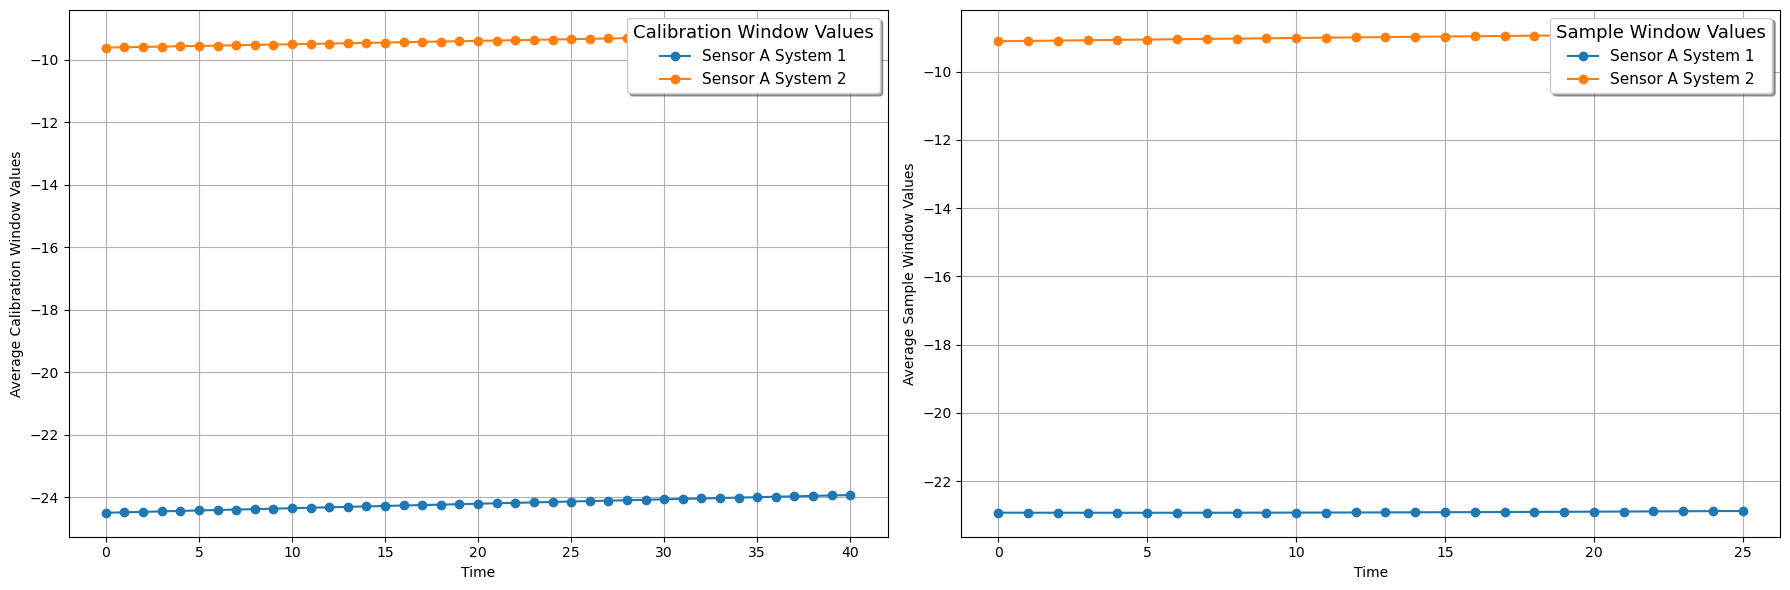

In [221]:
# Plot the window for sensor A
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot the first window for sensor A
axs[0].plot(A1_cal_window.columns, A1_cal_window.mean(), marker='o', linestyle='-', label='Sensor A System 1')
# axs[0].fill_between(A1_cal_window.columns.to_numpy(), A1_cal_window.mean() - A1_cal_window.std(), A1_cal_window.mean() - A1_cal_window.std(), color='blue', alpha=0.3)
axs[0].plot(A2_cal_window.columns, A2_cal_window.mean(), marker='o', linestyle='-', label='Sensor A System 2')
# axs[0].fill_between(A2_cal_window.columns.to_numpy(), A2_cal_window.mean() - A2_cal_window.std(), A2_cal_window.mean() + A2_cal_window.std(), color='red', alpha=0.3)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Average Calibration Window Values')
axs[0].legend(title='Calibration Window Values', title_fontsize='13', fontsize='11', loc='upper right', frameon=True, shadow=True, fancybox=True)
axs[0].grid(True)

# Plot the second window for sensor A
axs[1].plot(A1_sample_window.columns, A1_sample_window.mean(), marker='o', linestyle='-', label='Sensor A System 1')
axs[1].plot(A2_sample_window.columns, A2_sample_window.mean(), marker='o', linestyle='-', label='Sensor A System 2')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Average Sample Window Values')
axs[1].legend(title='Sample Window Values', title_fontsize='13', fontsize='11', loc='upper right', frameon=True, shadow=True, fancybox=True)
axs[1].grid(True)

plt.tight_layout()
plt.show()


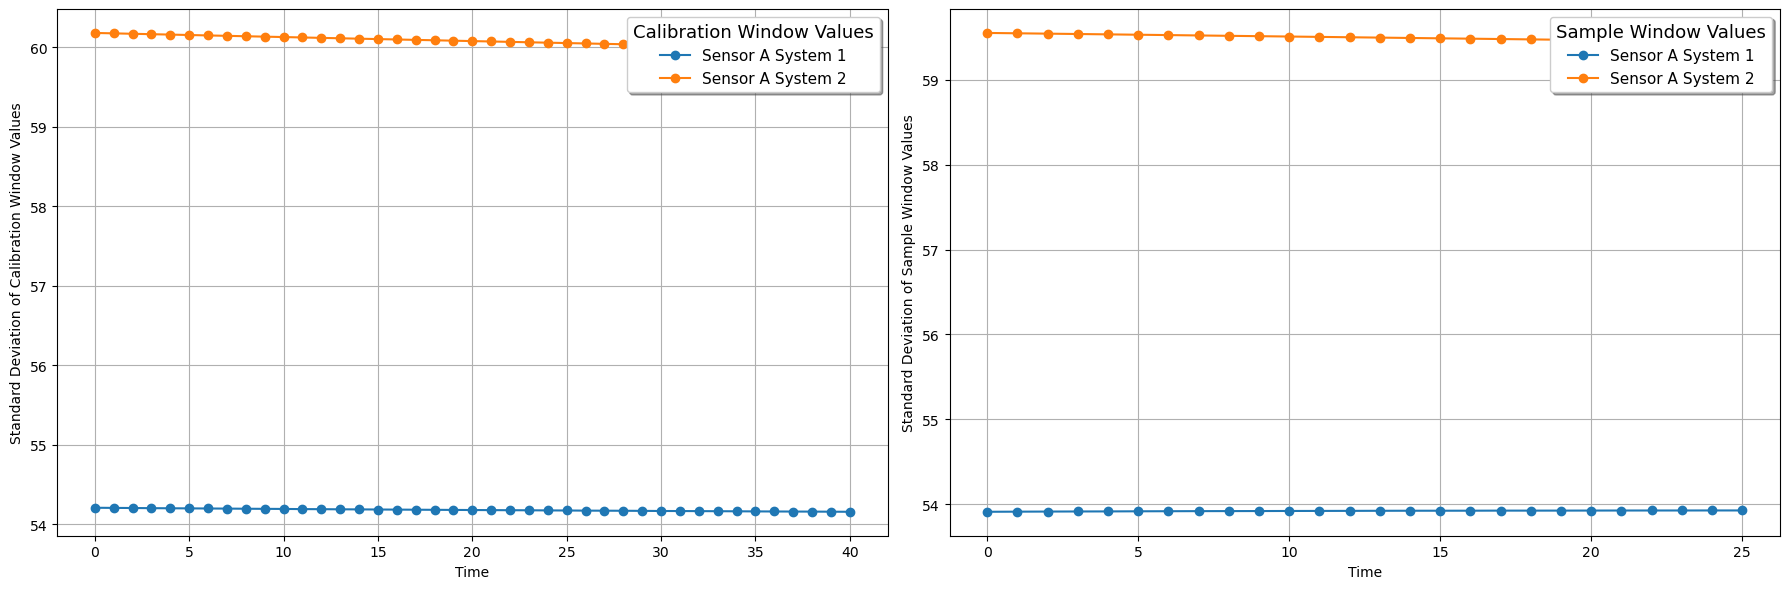

In [222]:
# Plot the window for sensor A
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot the first window for sensor A
axs[0].plot(A1_cal_window.columns, A1_cal_window.std(), marker='o', linestyle='-', label='Sensor A System 1')
axs[0].plot(A2_cal_window.columns, A2_cal_window.std(), marker='o', linestyle='-', label='Sensor A System 2')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Standard Deviation of Calibration Window Values')
axs[0].legend(title='Calibration Window Values', title_fontsize='13', fontsize='11', loc='upper right', frameon=True, shadow=True, fancybox=True)
axs[0].grid(True)

# Plot the second window for sensor A
axs[1].plot(A1_sample_window.columns, A1_sample_window.std(), marker='o', linestyle='-', label='Sensor A System 1')
axs[1].plot(A2_sample_window.columns, A2_sample_window.std(), marker='o', linestyle='-', label='Sensor A System 2')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Standard Deviation of Sample Window Values')
axs[1].legend(title='Sample Window Values', title_fontsize='13', fontsize='11', loc='upper right', frameon=True, shadow=True, fancybox=True)
axs[1].grid(True)

plt.tight_layout()
plt.show()

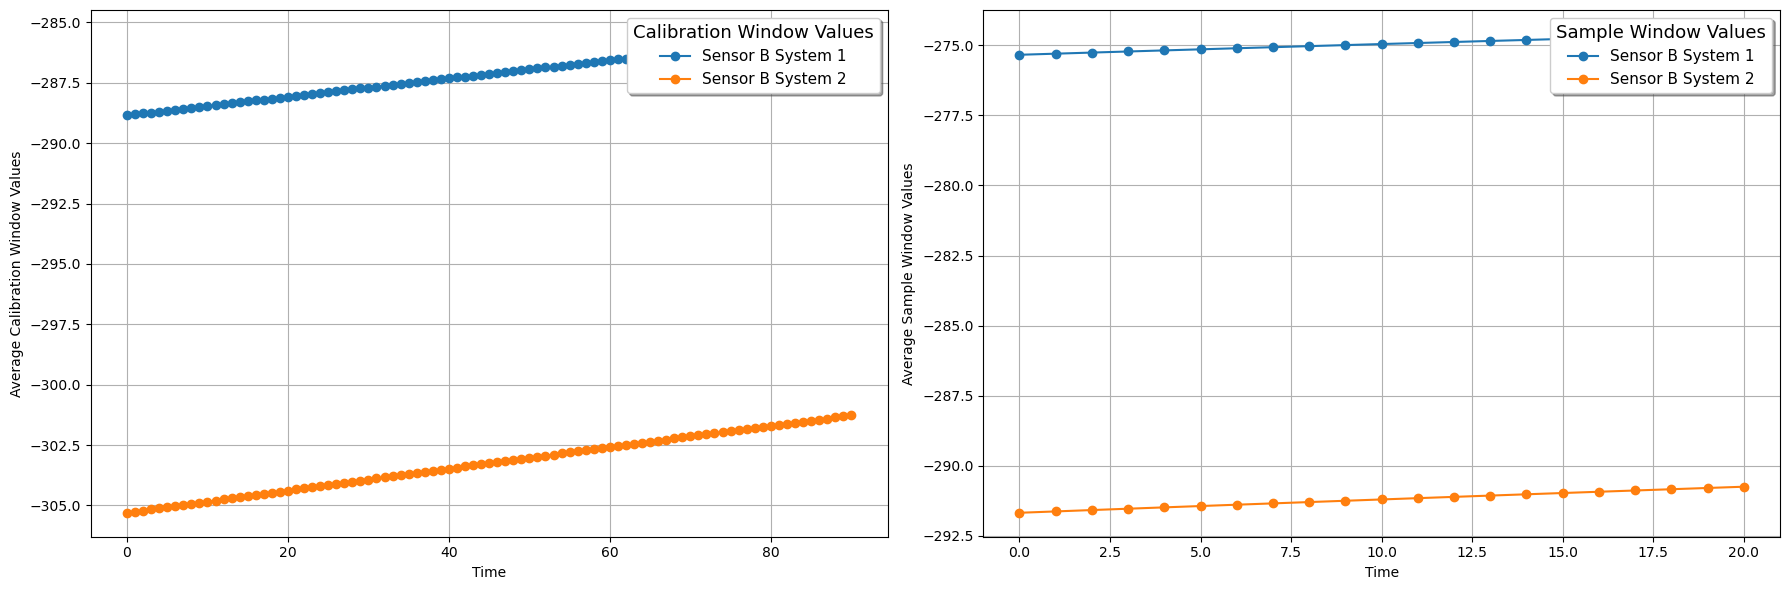

In [223]:
# Plot the window for sensor B
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot the first window for sensor B
axs[0].plot(B1_cal_window.columns, B1_cal_window.mean(), marker='o', linestyle='-', label='Sensor B System 1')
axs[0].plot(B2_cal_window.columns, B2_cal_window.mean(), marker='o', linestyle='-', label='Sensor B System 2')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Average Calibration Window Values')
axs[0].legend(title='Calibration Window Values', title_fontsize='13', fontsize='11', loc='upper right', frameon=True, shadow=True, fancybox=True)
axs[0].grid(True)

# Plot the second window for sensor B
axs[1].plot(B1_sample_window.columns, B1_sample_window.mean(), marker='o', linestyle='-', label='Sensor B System 1')
axs[1].plot(B2_sample_window.columns, B2_sample_window.mean(), marker='o', linestyle='-', label='Sensor B System 2')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Average Sample Window Values')
axs[1].legend(title='Sample Window Values', title_fontsize='13', fontsize='11', loc='upper right', frameon=True, shadow=True, fancybox=True)
axs[1].grid(True)

plt.tight_layout()
plt.show()

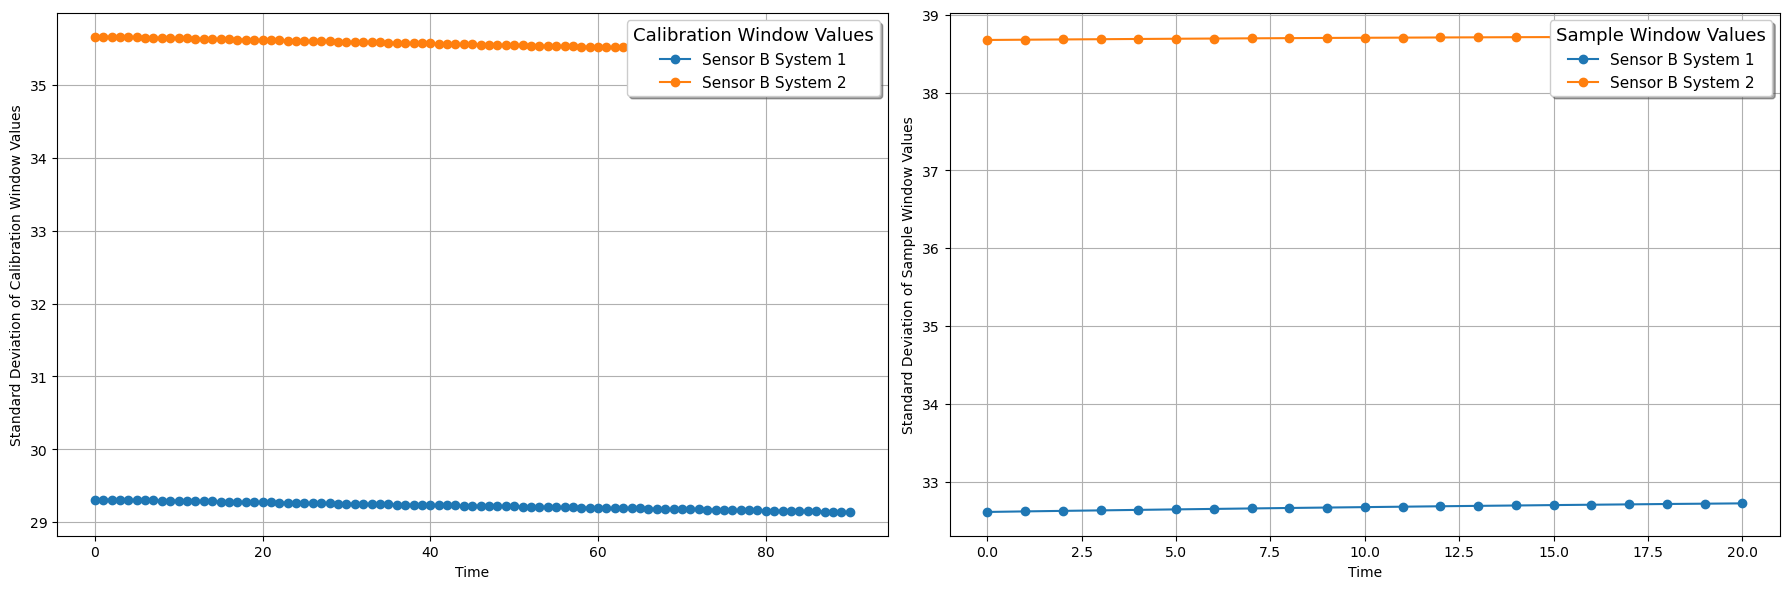

In [224]:
# Plot the window for sensor B
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot the first window for sensor B
axs[0].plot(B1_cal_window.columns, B1_cal_window.std(), marker='o', linestyle='-', label='Sensor B System 1')
axs[0].plot(B2_cal_window.columns, B2_cal_window.std(), marker='o', linestyle='-', label='Sensor B System 2')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Standard Deviation of Calibration Window Values')
axs[0].legend(title='Calibration Window Values', title_fontsize='13', fontsize='11', loc='upper right', frameon=True, shadow=True, fancybox=True)
axs[0].grid(True)

# Plot the second window for sensor B
axs[1].plot(B1_sample_window.columns, B1_sample_window.std(), marker='o', linestyle='-', label='Sensor B System 1')
axs[1].plot(B2_sample_window.columns, B2_sample_window.std(), marker='o', linestyle='-', label='Sensor B System 2')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Standard Deviation of Sample Window Values')
axs[1].legend(title='Sample Window Values', title_fontsize='13', fontsize='11', loc='upper right', frameon=True, shadow=True, fancybox=True)
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [225]:
# Calculate metrics of average window data for sensor A
cal_metrics=[[A1_cal_window.mean().mean(),A2_cal_window.mean().mean()],
            [A1_cal_window.mean().std(),A2_cal_window.mean().std()],
            [(A1_cal_window.mean().max()-A1_cal_window.mean().min())/A1_cal_window.mean().mean(),
            (A2_cal_window.mean().max()-A2_cal_window.mean().min())/A2_cal_window.mean().mean()]]
cal_metrics_summary = pd.DataFrame(cal_metrics, columns=['A1-cal','A2-cal'], index=['mean','sd','slope'])
print(cal_metrics_summary)
print()
sample_metrics=[[A1_sample_window.mean().mean(),A2_sample_window.mean().mean()],
            [A1_sample_window.mean().std(),A2_sample_window.mean().std()],
            [(A1_sample_window.mean().max()-A1_sample_window.mean().min())/A1_sample_window.mean().mean(),
            (A2_sample_window.mean().max()-A2_sample_window.mean().min())/A2_sample_window.mean().mean()]]
sample_metrics_summary = pd.DataFrame(sample_metrics, columns=['A1-sample','A2-sample'], index=['mean','sd','slope'])
print(sample_metrics_summary)

          A1-cal    A2-cal
mean  -24.203128 -9.393469
sd      0.169811  0.130269
slope  -0.023429 -0.046404

       A1-sample  A2-sample
mean  -22.912249  -8.993571
sd      0.017009   0.065522
slope  -0.002295  -0.023797


In [226]:
# Calculate metrics of average window data for sensor B
cal_metrics=[[B1_cal_window.mean().mean(),B2_cal_window.mean().mean()],
            [B1_cal_window.mean().std(),B2_cal_window.mean().std()],
            [(B1_cal_window.mean().max()-B1_cal_window.mean().min())/B1_cal_window.mean().mean(),
            (B2_cal_window.mean().max()-B2_cal_window.mean().min())/B2_cal_window.mean().mean()]]
cal_metrics_summary = pd.DataFrame(cal_metrics, columns=['B1-cal','B2-cal'], index=['mean','sd','slope'])
print(cal_metrics_summary)
print()
sample_metrics=[[B1_sample_window.mean().mean(),B2_sample_window.mean().mean()],
            [B1_sample_window.mean().std(),B2_sample_window.mean().std()],
            [(B1_sample_window.mean().max()-B1_sample_window.mean().min())/B1_sample_window.mean().mean(),
            (B2_sample_window.mean().max()-B2_sample_window.mean().min())/B2_sample_window.mean().mean()]]
sample_metrics_summary = pd.DataFrame(sample_metrics, columns=['B1-sample','B2-sample'], index=['mean','sd','slope'])
print(sample_metrics_summary)

           B1-cal      B2-cal
mean  -287.140933 -303.261507
sd       0.990252    1.184286
slope   -0.011728   -0.013301

        B1-sample   B2-sample
mean  -274.959814 -291.207365
sd       0.230525    0.288276
slope   -0.002703   -0.003192


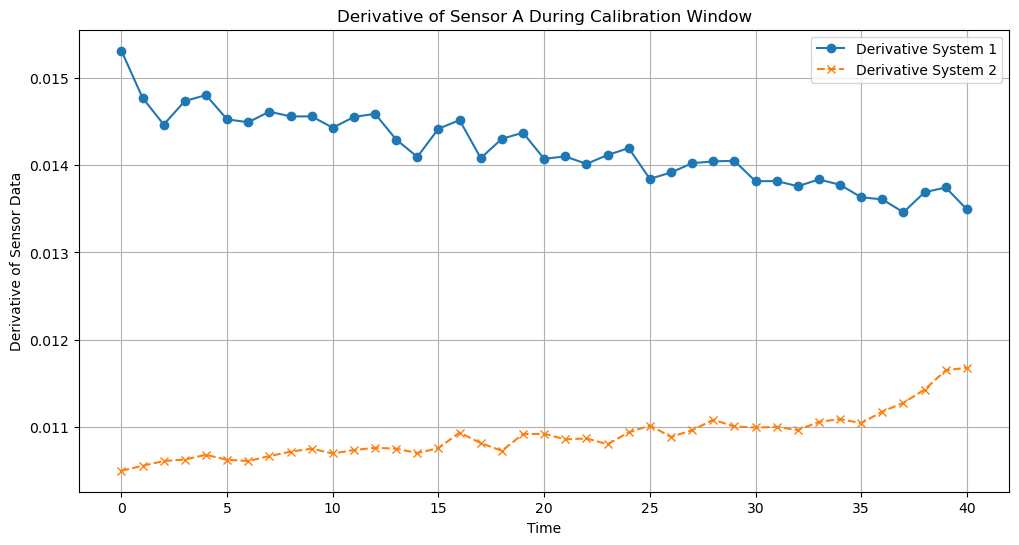

In [227]:
# Calibration window derivative trend for sensor A
# Calculate the derivative of sensor data
A1_cal_window_derivative = np.gradient(A1_cal_window.mean(), A1_cal_window.columns)
A2_cal_window_derivative = np.gradient(A2_cal_window.mean(), A2_cal_window.columns)

# Plotting the derivatives
plt.figure(figsize=(12, 6))
plt.plot(A1_cal_window_derivative, label='Derivative System 1', marker='o', linestyle='-')
plt.plot(A2_cal_window_derivative, label='Derivative System 2', marker='x', linestyle='--')

plt.title('Derivative of Sensor A During Calibration Window')
plt.xlabel('Time')
plt.ylabel('Derivative of Sensor Data')
plt.legend()
plt.grid(True)
plt.show()

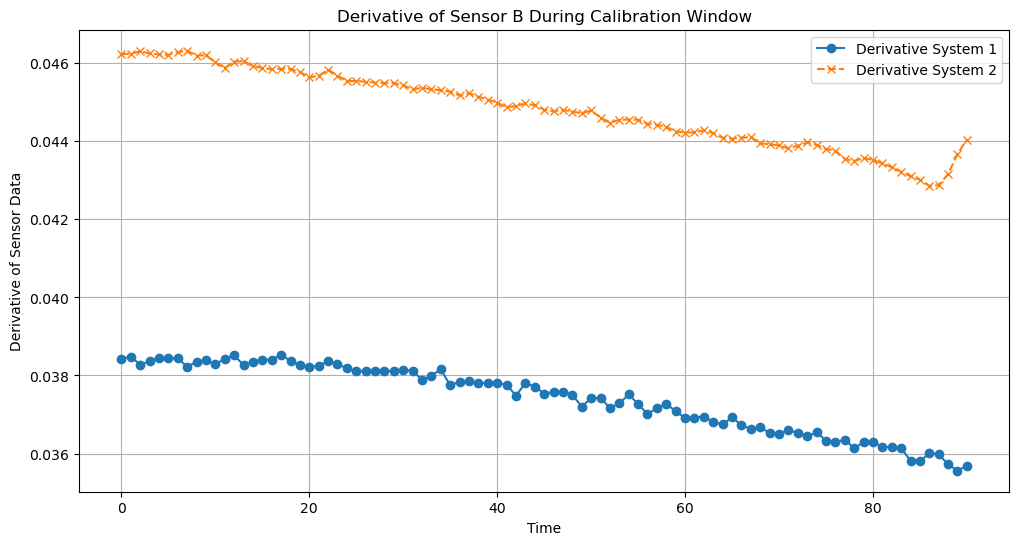

In [228]:
# Calibration window derivative trend for sensor B
# Calculate the derivative of sensor data
B1_cal_window_derivative = np.gradient(B1_cal_window.mean(), B1_cal_window.columns)
B2_cal_window_derivative = np.gradient(B2_cal_window.mean(), B2_cal_window.columns)

# Plotting the derivatives
plt.figure(figsize=(12, 6))
plt.plot(B1_cal_window_derivative, label='Derivative System 1', marker='o', linestyle='-')
plt.plot(B2_cal_window_derivative, label='Derivative System 2', marker='x', linestyle='--')

plt.title('Derivative of Sensor B During Calibration Window')
plt.xlabel('Time')
plt.ylabel('Derivative of Sensor Data')
plt.legend()
plt.grid(True)
plt.show()

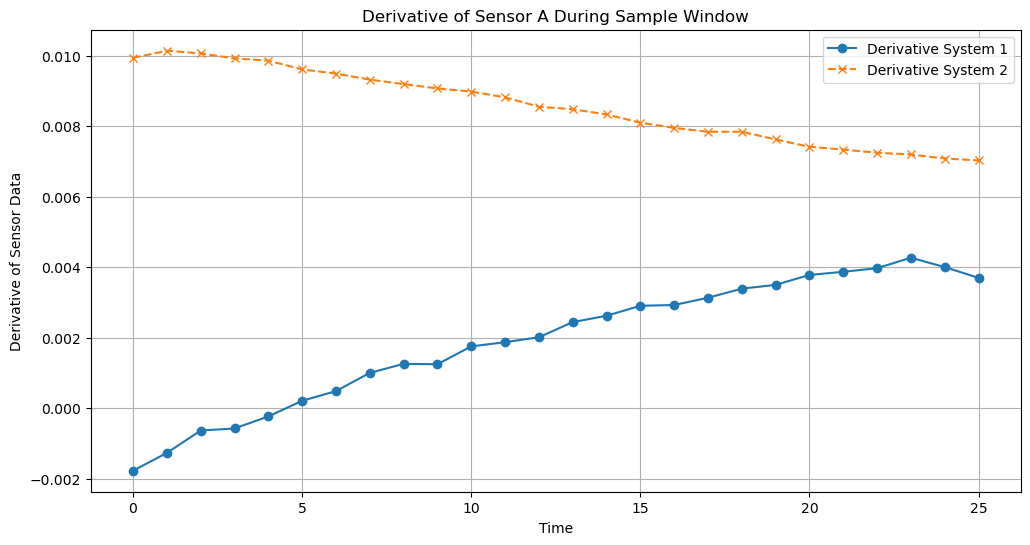

In [229]:
# Sample window derivative trend for sensor A
# Calculate the derivative of sensor data
A1_sample_window_derivative = np.gradient(A1_sample_window.mean(), A1_sample_window.columns)
A2_sample_window_derivative = np.gradient(A2_sample_window.mean(), A2_sample_window.columns)

# Plotting the derivatives
plt.figure(figsize=(12, 6))
plt.plot(A1_sample_window_derivative, label='Derivative System 1', marker='o', linestyle='-')
plt.plot(A2_sample_window_derivative, label='Derivative System 2', marker='x', linestyle='--')

plt.title('Derivative of Sensor A During Sample Window')
plt.xlabel('Time')
plt.ylabel('Derivative of Sensor Data')
plt.legend()
plt.grid(True)
plt.show()

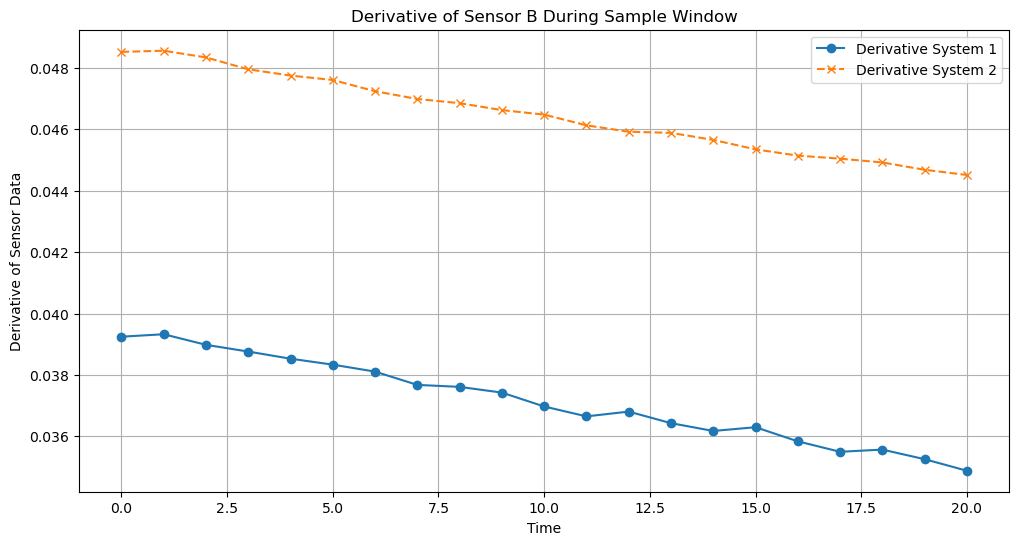

In [230]:
# Sample window derivative trend for sensor B
# Calculate the derivative of sensor data
B1_sample_window_derivative = np.gradient(B1_sample_window.mean(), B1_sample_window.columns)
B2_sample_window_derivative = np.gradient(B2_sample_window.mean(), B2_sample_window.columns)

# Plotting the derivatives
plt.figure(figsize=(12, 6))
plt.plot(B1_sample_window_derivative, label='Derivative System 1', marker='o', linestyle='-')
plt.plot(B2_sample_window_derivative, label='Derivative System 2', marker='x', linestyle='--')

plt.title('Derivative of Sensor B During Sample Window')
plt.xlabel('Time')
plt.ylabel('Derivative of Sensor Data')
plt.legend()
plt.grid(True)
plt.show()

In [231]:
import altair as alt
from altair_data_server import data_server
alt.data_transformers.enable('vegafusion')
A_Merged = pd.concat([A1_Merged, A2_Merged], ignore_index=True)
A_Merged = A_Merged.assign(System=np.where(A_Merged.index < len(A1_Merged), 'System1', 'System2'))
df = A_Merged[['FluidType','AgeOfCardInDaysAtTimeOfTest','AmbientTemperature','System']]
df['Type'] = df['FluidType'].apply(lambda x: 'Eurotrol' if x.startswith('Eurotrol') else 'Blood')
cardage = alt.Chart(df).mark_boxplot().encode(
    y=alt.Y('AgeOfCardInDaysAtTimeOfTest:Q', title='Card Age'),
    x='System'
    ).properties(width=200, height=200)

temperature = alt.Chart(df).mark_boxplot().encode(
    y=alt.Y('AmbientTemperature:Q',title='Temperature'),
    x='System'
).properties(width=200, height=200)

FluidType = alt.Chart(df).mark_bar().encode(
    x='System:N',
    y='count()',
    color='Type'
).properties(width=200, height=200)

cardage | temperature | FluidType

/var/folders/wn/68bcm5yd52xfzp9jfr0tdddc0000gn/T/ipykernel_12449/2752349317.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Type'] = df['FluidType'].apply(lambda x: 'Eurotrol' if x.startswith('Eurotrol') else 'Blood')


alt.HConcatChart(...)

### K-means clustering by sensor values

In [212]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# Merge system 1 and 2
A_cal_window = pd.concat([A1_cal_window, A2_cal_window])
A_sample_window = pd.concat([A1_sample_window, A2_sample_window])
B_cal_window = pd.concat([B1_cal_window, B2_cal_window])
B_sample_window = pd.concat([B1_sample_window, B2_sample_window])

# Technique 1: Normalize data
A_cal_window_normalized = StandardScaler().fit_transform(A_cal_window)
A_sample_window_normalized = StandardScaler().fit_transform(A_sample_window)
B_cal_window_normalized = StandardScaler().fit_transform(B_cal_window)
B_sample_window_normalized = StandardScaler().fit_transform(B_sample_window)

# Technique 2: Put the beginning of all sensor data at the same value (zero)
A_cal_window_zero = A_cal_window.iloc[:, 1:].sub(A_cal_window.iloc[:, 1], axis=0)
A_sample_window_zero = A_sample_window.iloc[:, 1:].sub(A_sample_window.iloc[:, 1], axis=0)
B_cal_window_zero = B_cal_window.iloc[:, 1:].sub(B_cal_window.iloc[:, 1], axis=0)
B_sample_window_zero = B_sample_window.iloc[:, 1:].sub(B_sample_window.iloc[:, 1], axis=0)


/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will c

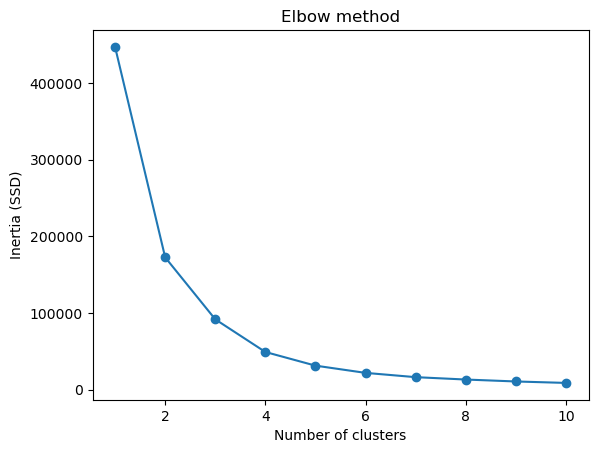

In [59]:
# sensorA calibration window
inertias_cal_A = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i).fit(A_cal_window_normalized)
    inertias_cal_A.append(kmeans.inertia_)

plt.plot(range(1,11), inertias_cal_A, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (SSD)')
plt.show()

/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will c

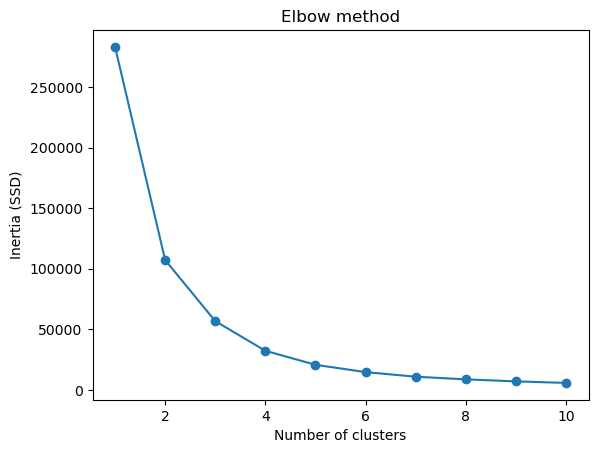

In [60]:
# sensorA sample window
inertias_sample_A = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i).fit(A_sample_window_normalized)
    inertias_sample_A.append(kmeans.inertia_)

plt.plot(range(1,11), inertias_sample_A, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (SSD)')
plt.show()

/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will c

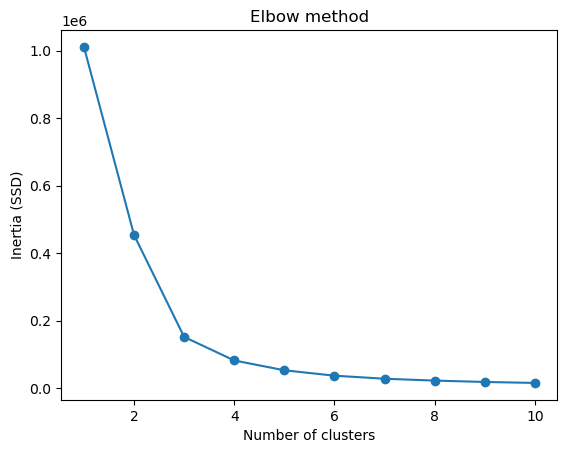

In [61]:
# sensorB calibration window
inertias_cal_B = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i).fit(B_cal_window_normalized)
    inertias_cal_B.append(kmeans.inertia_)

plt.plot(range(1,11), inertias_cal_B, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (SSD)')
plt.show()

/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will c

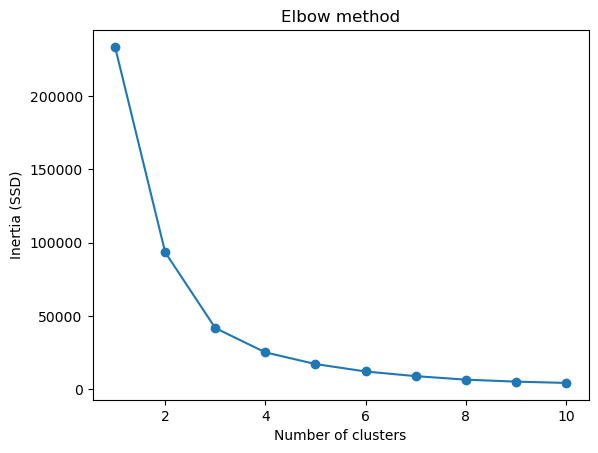

In [62]:
# sensorB sample window
inertias_sample_B = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i).fit(B_sample_window_normalized)
    inertias_sample_B.append(kmeans.inertia_)

plt.plot(range(1,11), inertias_sample_B, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (SSD)')
plt.show()

In [63]:
n_clusters = 3

#### Euclidean K-means on normalized data

In [64]:
# Sensor A Cal Window
model_euclidean= KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred = model_euclidean.fit_predict(A_cal_window_normalized)

/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


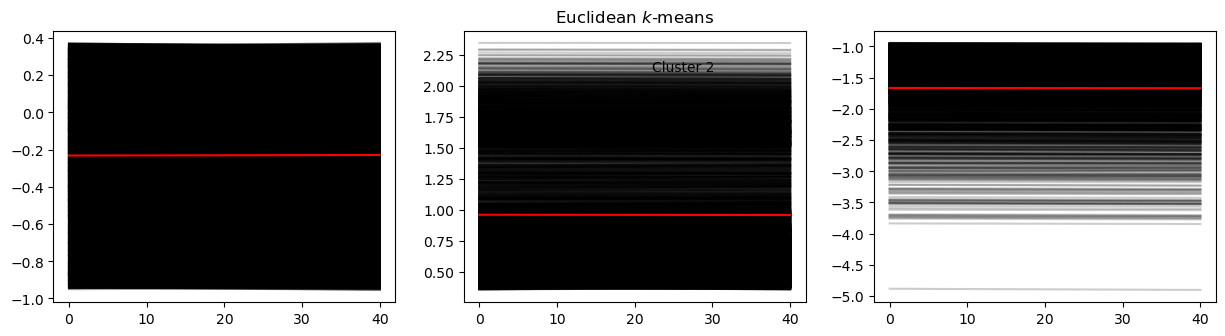

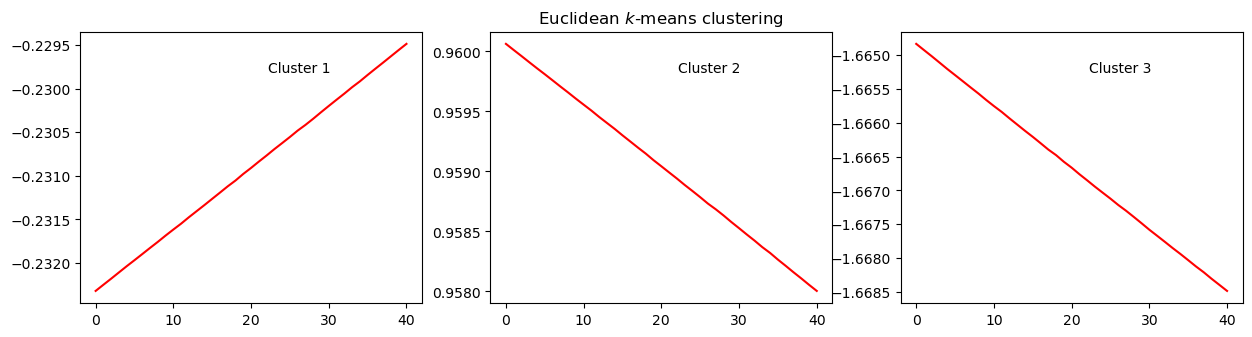

In [65]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in A_cal_window_normalized[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means clustering")

In [66]:
# sensor A sample window
model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred = model_euclidean.fit_predict(A_sample_window_normalized)

/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


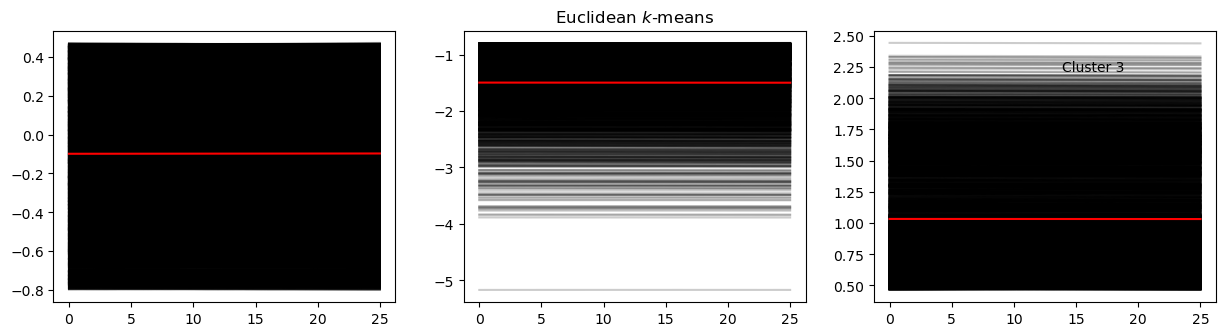

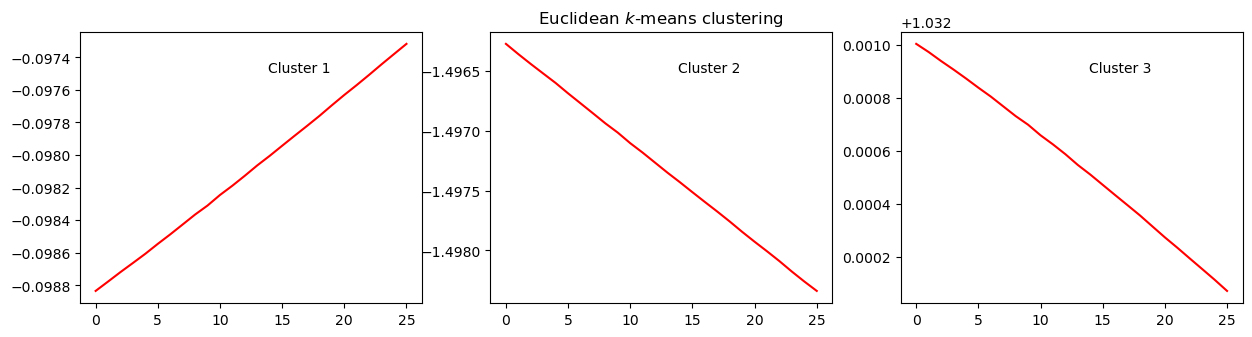

In [67]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in A_sample_window_normalized[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means clustering")

In [68]:
# sensor B cal window
model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred = model_euclidean.fit_predict(B_cal_window_normalized)

/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


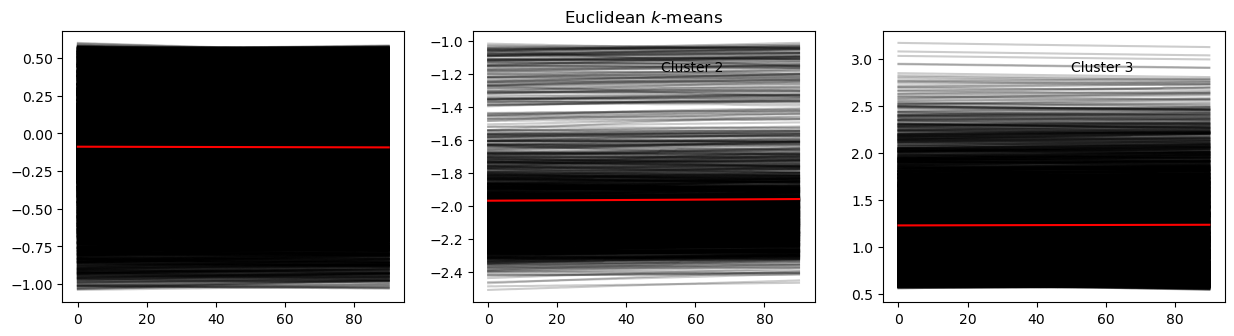

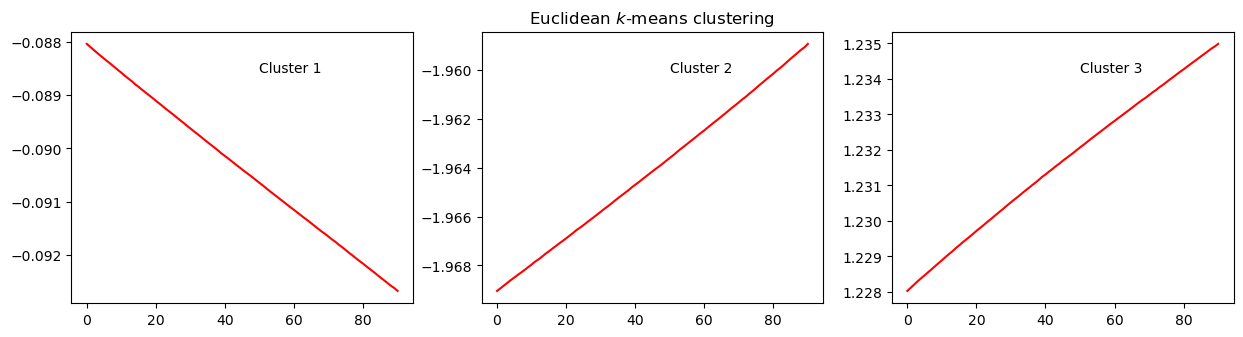

In [69]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in B_cal_window_normalized[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means clustering")

In [70]:
# sensor B sample window
model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred = model_euclidean.fit_predict(B_sample_window_normalized)

/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


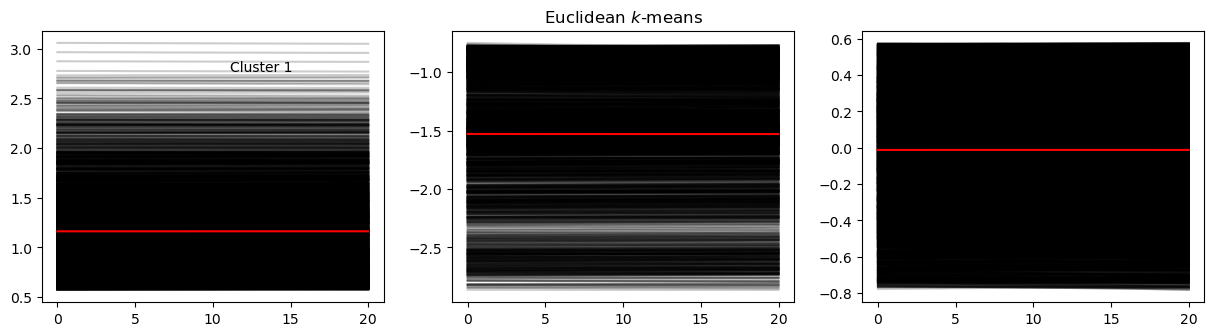

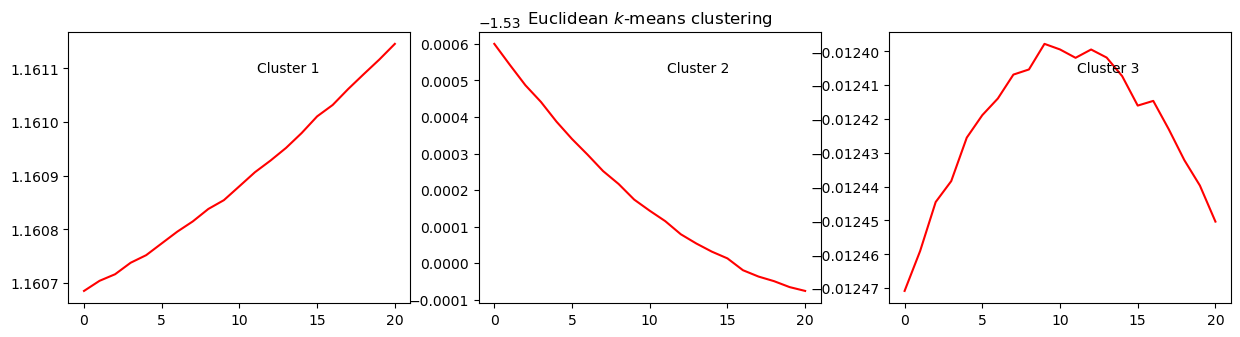

In [71]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in B_sample_window_normalized[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means clustering")

#### DTW K-means on normalized data

In [72]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw

# Sensor A cal window
data = A_cal_window_normalized.reshape(A_cal_window_normalized.shape[0], A_cal_window_normalized.shape[1],1)
model_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw",max_iter=10,
                         random_state=0)
model_dtw.fit(data)
y_pred_dtw = model_dtw.fit_predict(data)

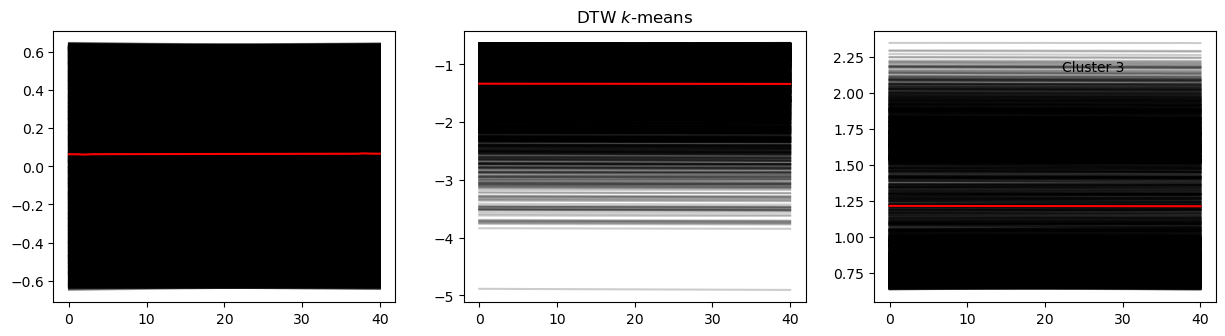

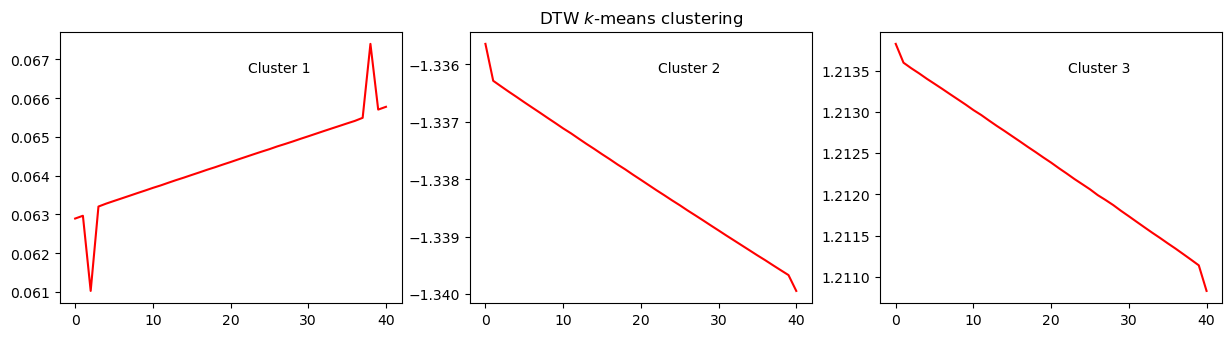

In [73]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in data[y_pred_dtw == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    # for xx in data[y_pred_dtw == yi]:
    #     plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means clustering")

In [74]:
# Sensor A sample window
data = A_sample_window_normalized.reshape(A_sample_window_normalized.shape[0], A_sample_window_normalized.shape[1],1)
model_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw",max_iter=10,
                         random_state=0)
model_dtw.fit(data)
y_pred_dtw = model_dtw.fit_predict(data)

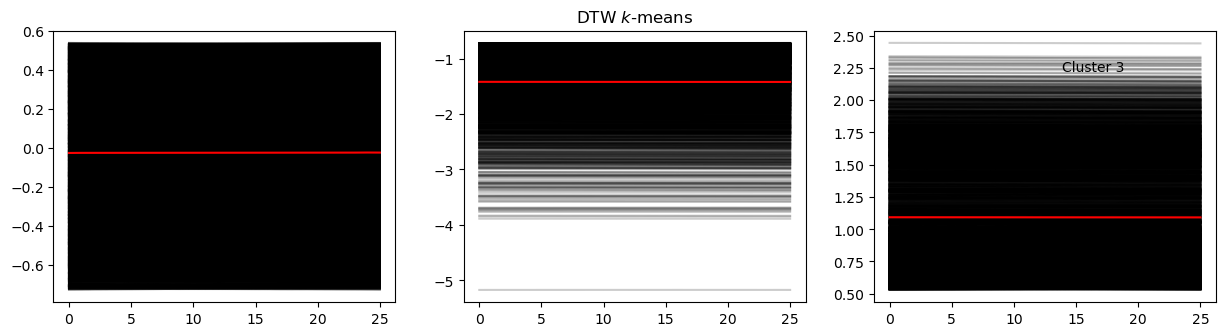

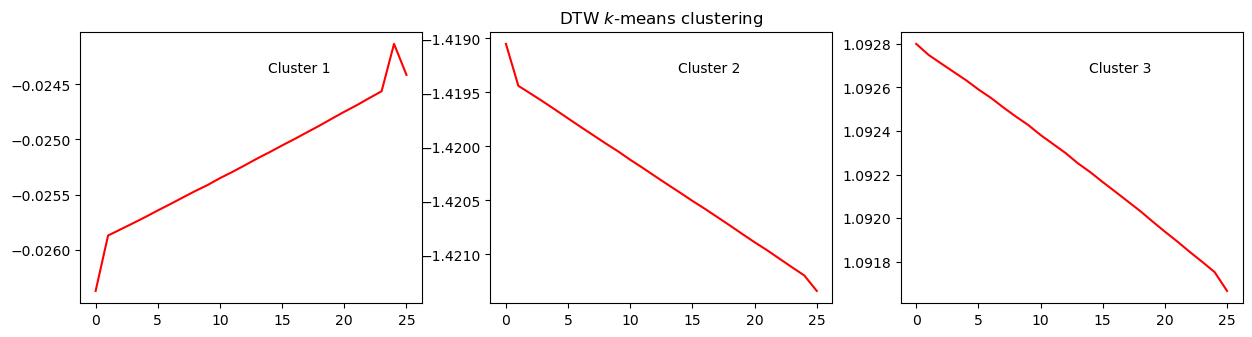

In [75]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in data[y_pred_dtw == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    # for xx in data[y_pred_dtw == yi]:
    #     plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means clustering")

In [76]:
# Sensor B cal window
data = B_cal_window_normalized.reshape(B_cal_window_normalized.shape[0], B_cal_window_normalized.shape[1],1)
model_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw",max_iter=10,
                         random_state=0)
model_dtw.fit(data)
y_pred_dtw = model_dtw.fit_predict(data)

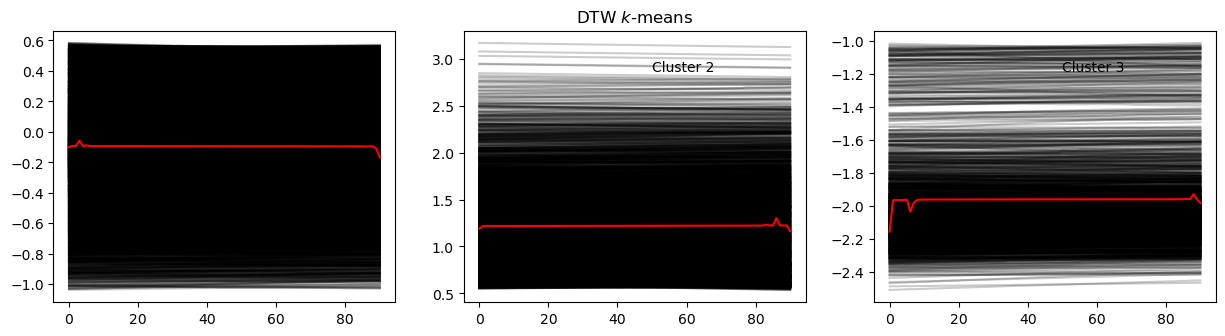

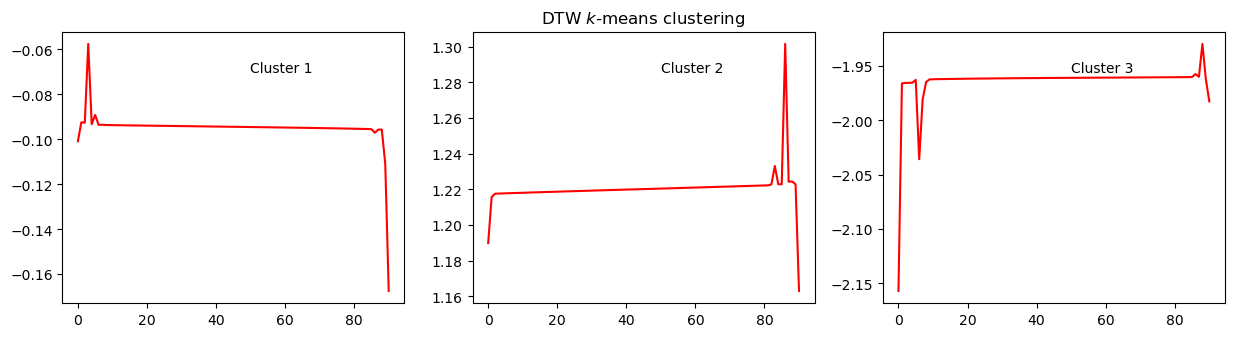

In [77]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in data[y_pred_dtw == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means clustering")

In [78]:
# Sensor B sample window
data = B_sample_window_normalized.reshape(B_sample_window_normalized.shape[0], B_sample_window_normalized.shape[1],1)
model_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw",max_iter=10,
                         random_state=0)
model_dtw.fit(data)
y_pred_dtw = model_dtw.fit_predict(data)

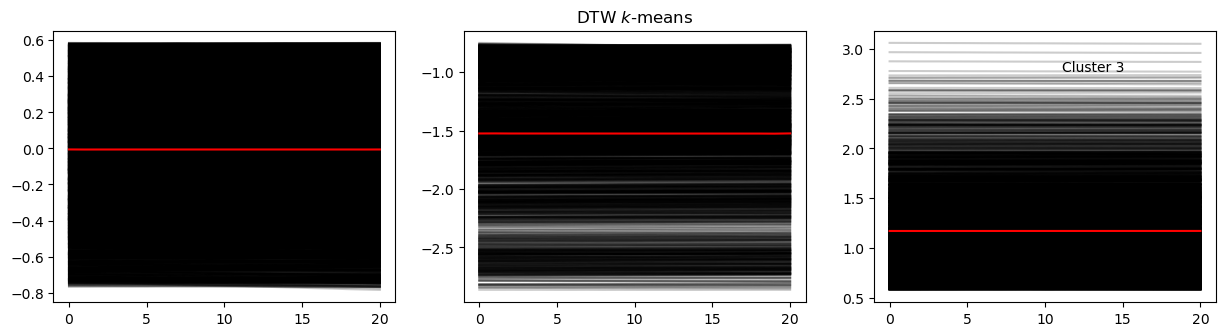

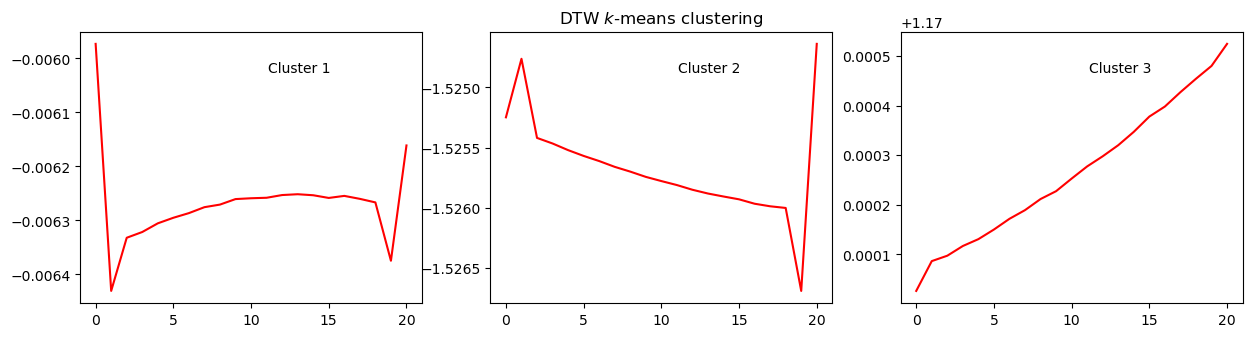

In [79]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in data[y_pred_dtw == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    # for xx in data[y_pred_dtw == yi]:
    #     plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means clustering")

#### Euclidean K-means on zero-beginning data

In [80]:
# Sensor A Cal Window
model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred = model_euclidean.fit_predict(A_cal_window_zero)

/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


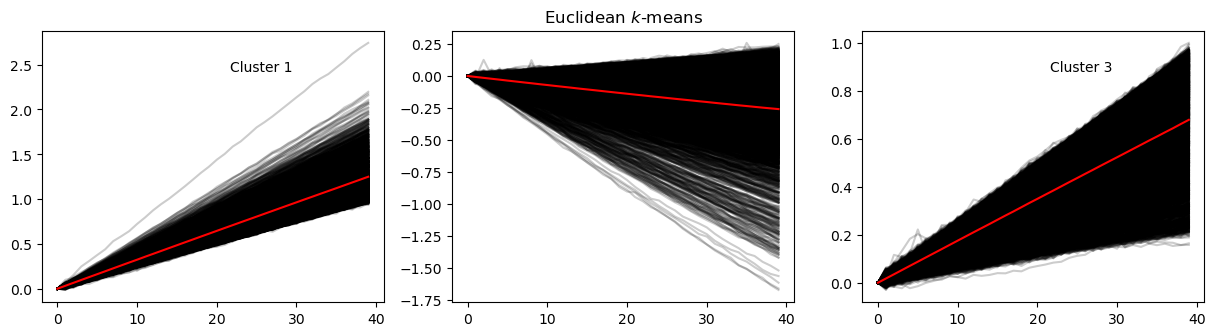

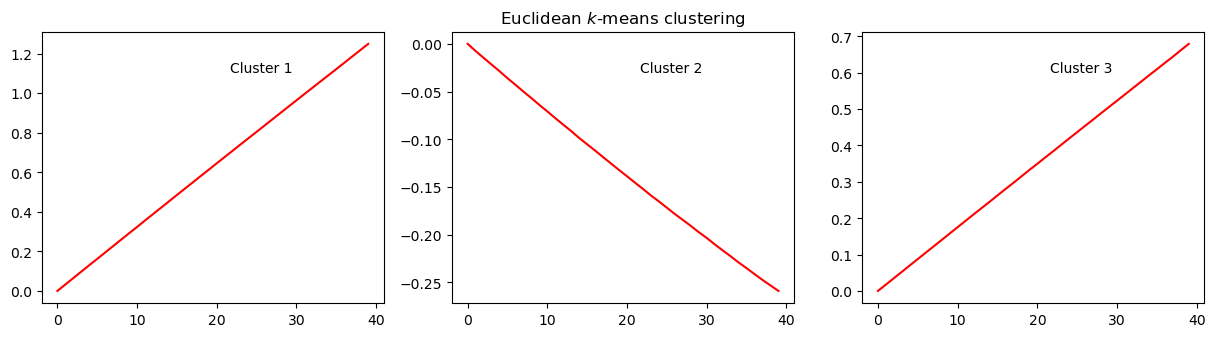

In [81]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for index, row in A_cal_window_zero[y_pred == yi].iterrows():
        plt.plot(row.ravel(), "k-", alpha=.2)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means clustering")

In [82]:
# Sensor A Sample Window
model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred = model_euclidean.fit_predict(A_sample_window_zero)

/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


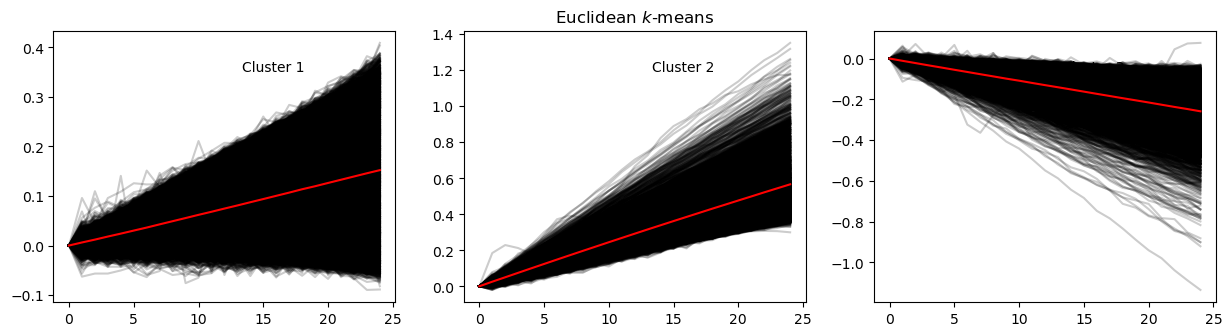

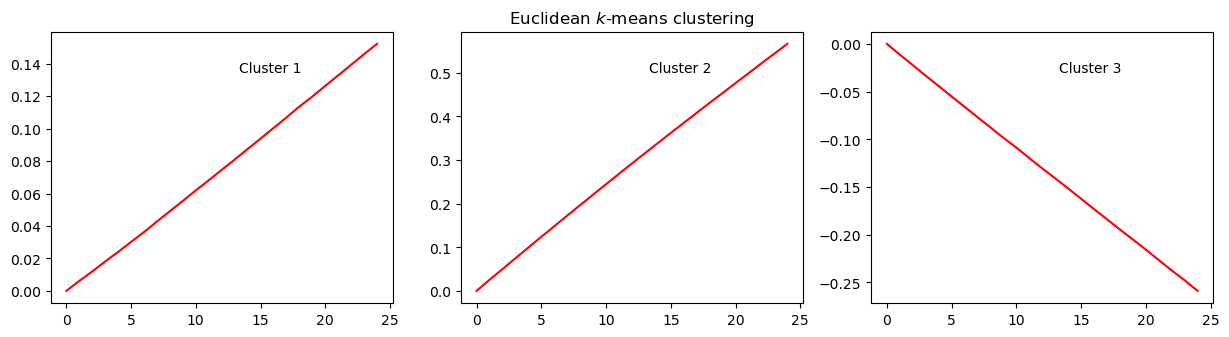

In [83]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for index, row in A_sample_window_zero[y_pred == yi].iterrows():
        plt.plot(row.ravel(), "k-", alpha=.2)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means clustering")

In [84]:
# Sensor B Cal Window
model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred = model_euclidean.fit_predict(B_cal_window_zero)

/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


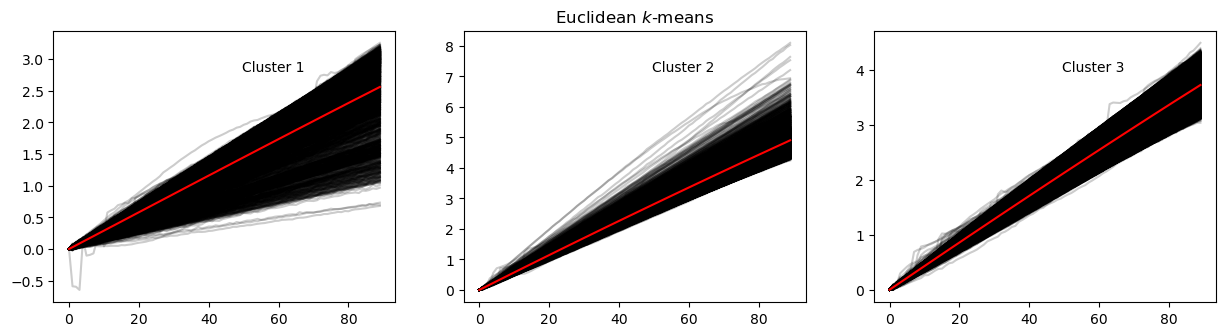

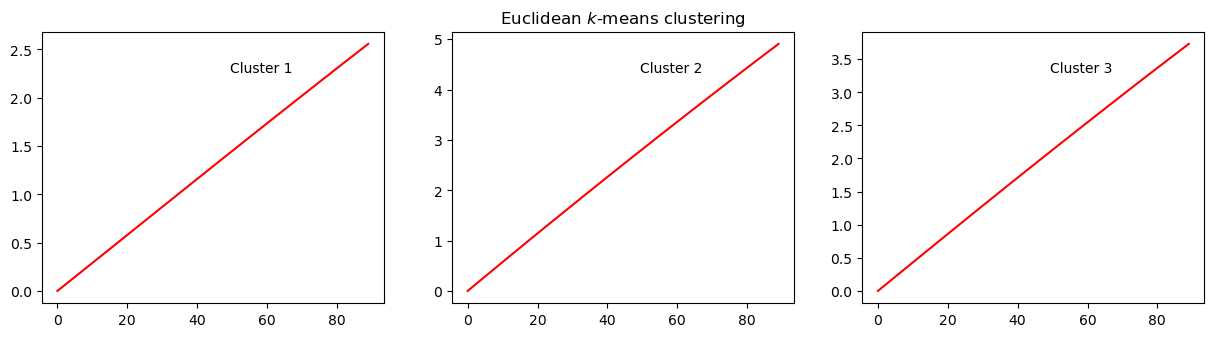

In [85]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for index, row in B_cal_window_zero[y_pred == yi].iterrows():
        plt.plot(row.ravel(), "k-", alpha=.2)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means clustering")

In [86]:
# Sensor B Sample Window
model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred = model_euclidean.fit_predict(B_sample_window_zero)

/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


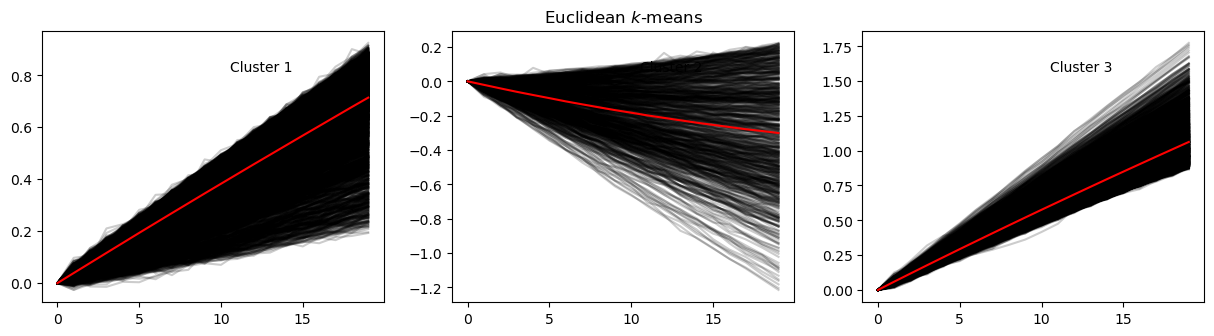

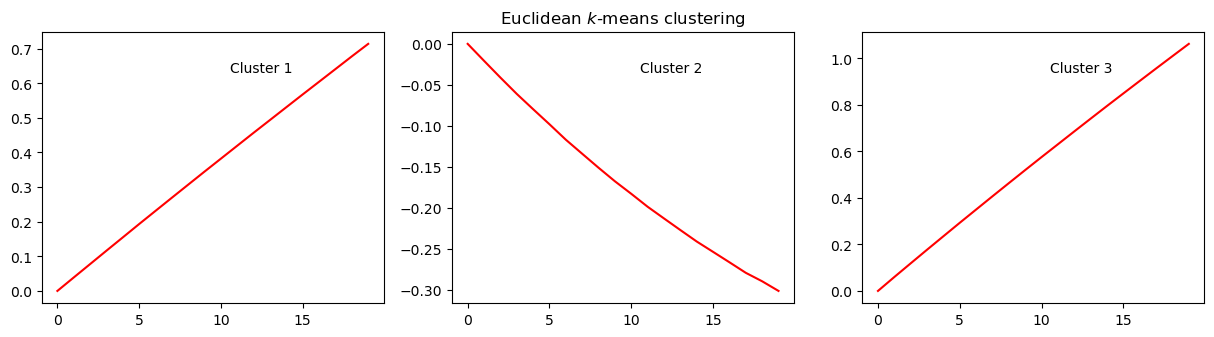

In [87]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for index, row in B_sample_window_zero[y_pred == yi].iterrows():
        plt.plot(row.ravel(), "k-", alpha=.2)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means clustering")

#### DTW K-means on zero-beginning data

In [88]:
# Sensor A cal Window
data = A_cal_window_zero.values.reshape(A_cal_window_zero.values.shape[0], A_cal_window_zero.values.shape[1],1)
model_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw",max_iter=10,
                         random_state=0)
model_dtw.fit(data)
y_pred_dtw = model_dtw.fit_predict(data)

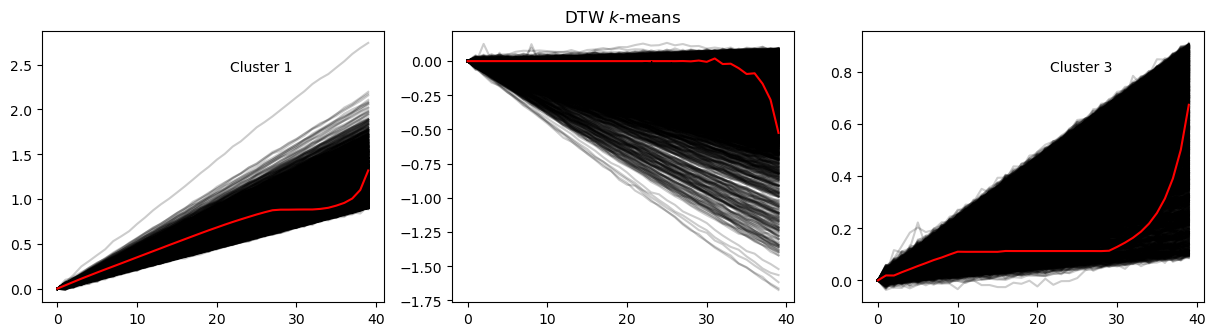

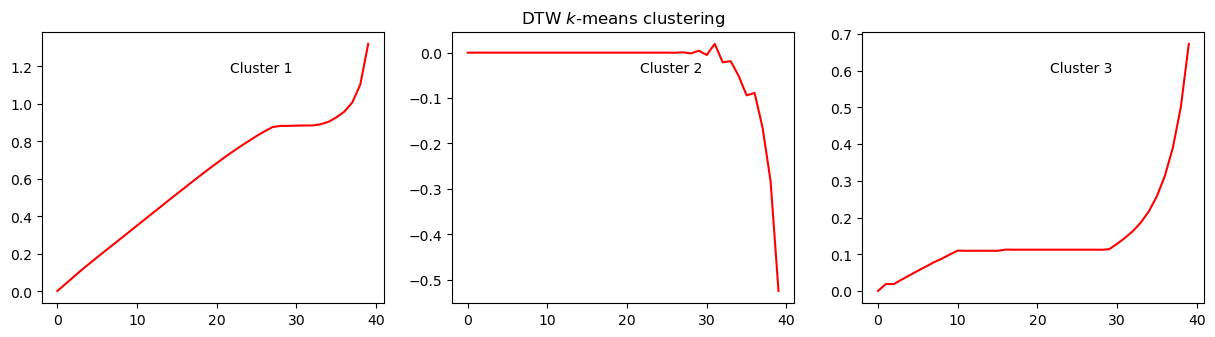

In [89]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in data[y_pred_dtw == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    # for xx in data[y_pred_dtw == yi]:
    #     plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means clustering")

In [90]:
# Sensor A sample Window
data = A_sample_window_zero.values.reshape(A_sample_window_zero.values.shape[0], A_sample_window_zero.values.shape[1],1)
model_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw",max_iter=10,
                         random_state=0)
model_dtw.fit(data)
y_pred_dtw = model_dtw.fit_predict(data)

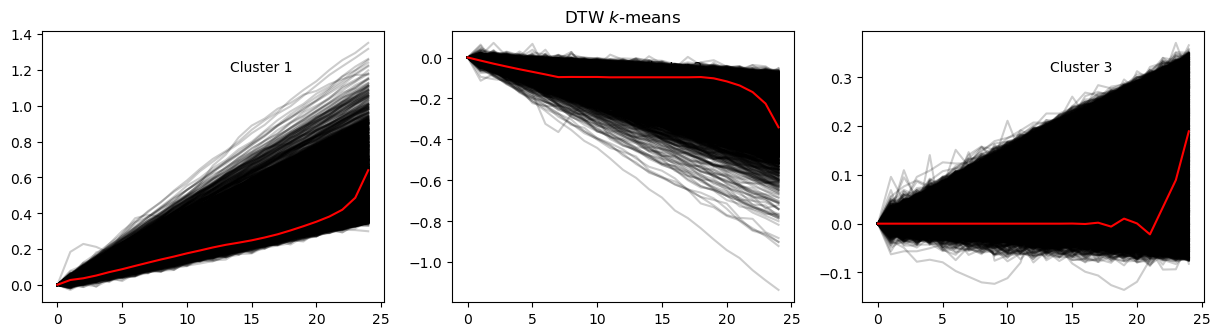

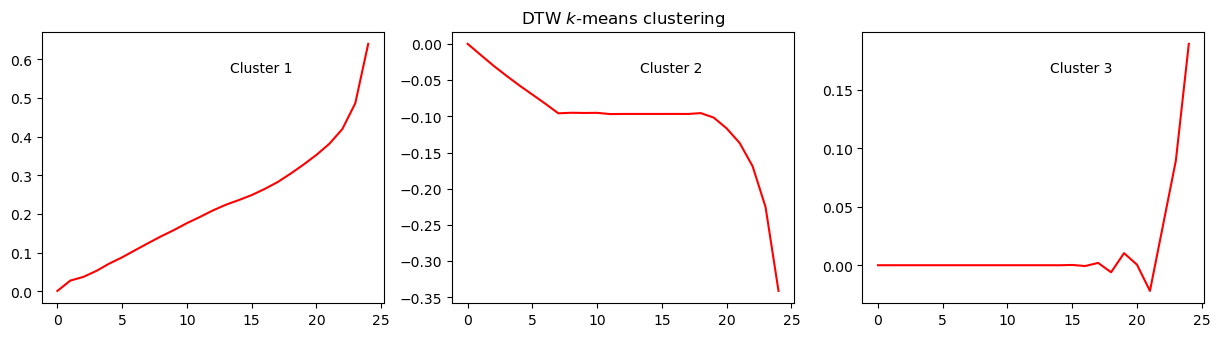

In [91]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in data[y_pred_dtw == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    # for xx in data[y_pred_dtw == yi]:
    #     plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means clustering")

In [92]:
# Sensor B cal Window
data = B_cal_window_zero.values.reshape(B_cal_window_zero.values.shape[0], B_cal_window_zero.values.shape[1],1)
model_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw",max_iter=10,
                         random_state=0)
model_dtw.fit(data)
y_pred_dtw = model_dtw.fit_predict(data)

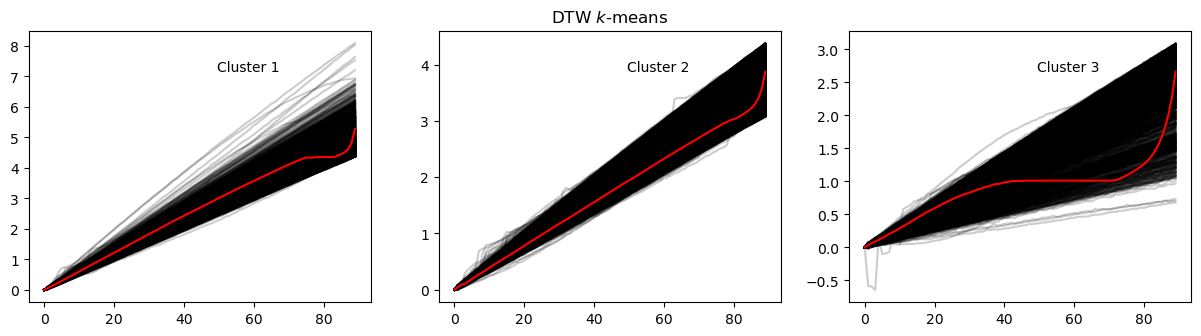

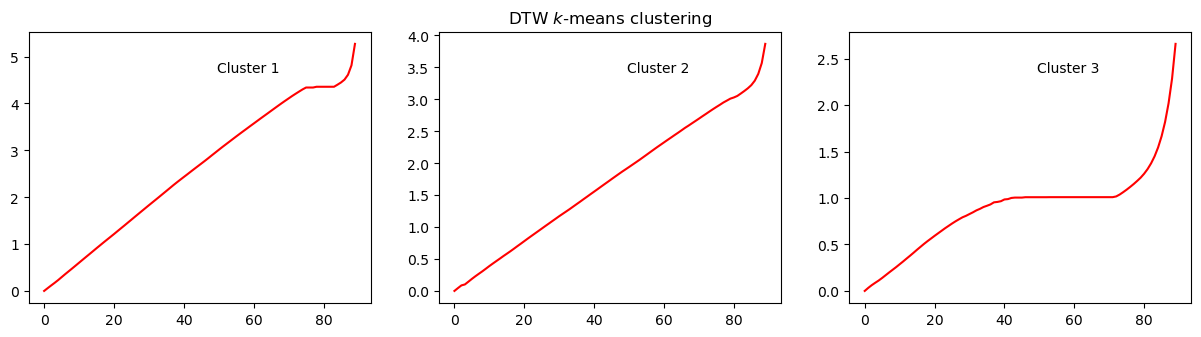

In [93]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in data[y_pred_dtw == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    # for xx in data[y_pred_dtw == yi]:
    #     plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means clustering")

In [94]:
# Sensor B sample Window
data = B_sample_window_zero.values.reshape(B_sample_window_zero.values.shape[0], B_sample_window_zero.values.shape[1],1)
model_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw",max_iter=10,
                         random_state=0)
model_dtw.fit(data)
y_pred_dtw = model_dtw.fit_predict(data)

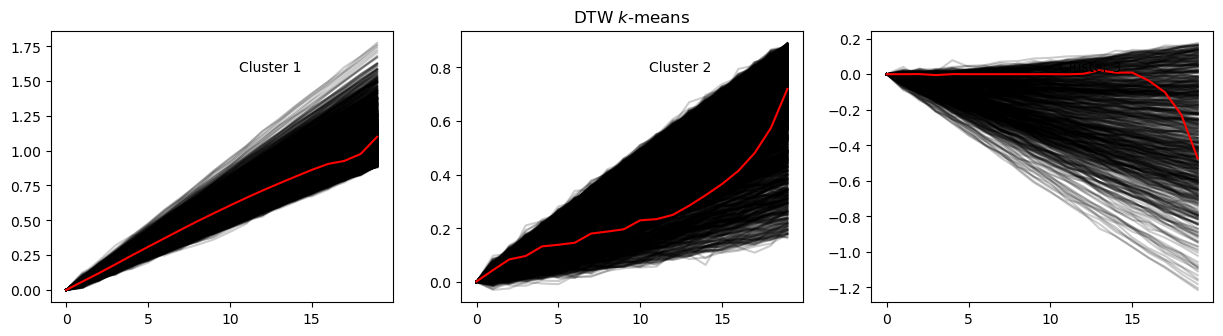

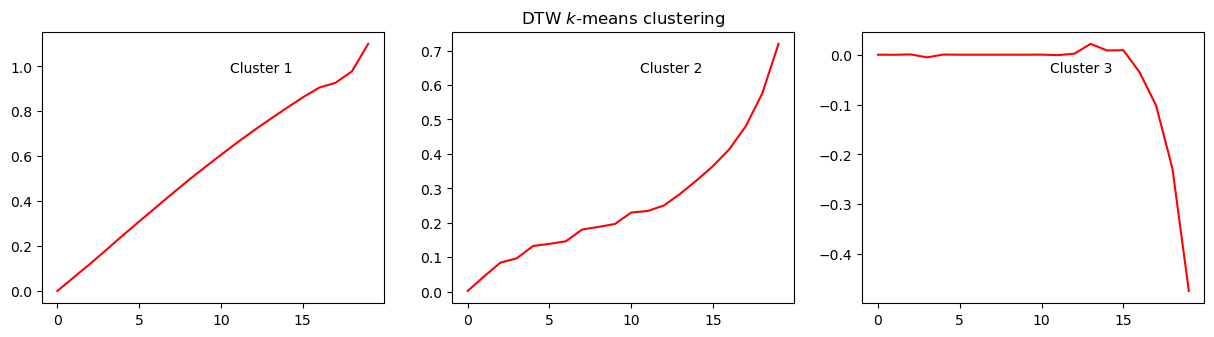

In [95]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in data[y_pred_dtw == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    # for xx in data[y_pred_dtw == yi]:
    #     plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means clustering")

In [282]:
# Plot for sensor A cal window
import altair as alt

model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred_euclid = model_euclidean.fit_predict(A_cal_window_zero)
df = A_cal_window_zero.reset_index()
df['label'] = y_pred_euclid
df2 = pd.merge(keyByTestID, df[['label','TestID']], how='inner', on=['TestID'])
df2['Type'] = df2['FluidType'].apply(lambda x: 'Eurotrol' if x.startswith('Eurotrol') else 'Blood')
df2['Systembi'] = df2['System'].apply(lambda x: 'System 1' if x=='System 1' else 'System 2')

cardage1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
cardage2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
cardage3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

temperature1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
temperature2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
temperature3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

FluidType1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
FluidType2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
FluidType3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

Type1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
Type2 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
Type3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

(cardage1 | cardage2 | cardage3) & (temperature1 | temperature2 | temperature3)  & (FluidType1 | FluidType2 | FluidType3)

/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


alt.VConcatChart(...)

In [283]:
# Sensor A Cal Window
# Count the number of Test IDs for each system within each cluster
test_id_counts = df2.groupby(['Systembi', 'label']).size().reset_index(name='count').sort_values(by=['label', 'Systembi']).reset_index(drop=True)

# Print the counts
print(test_id_counts)

   Systembi  label  count
0  System 1      0   1868
1  System 2      0   3476
2  System 1      1   2040
3  System 2      1   6202
4  System 1      2   2790
5  System 2      2   5436


In [265]:
# Sensor A Cal Window
# Seperate tests into three clusters


# cluster_1 = df2[df2['label'] == 0][['TestID', 'Systembi']]

# # Filtering and merging data for System 1
# cluster_1_data_s1 = pd.merge(cluster_1[cluster_1['Systembi'] == 'System 1']['TestID'], df, how='inner', on=['TestID']).drop("label", axis=1)
# cluster_1_data_s1.set_index('TestID', inplace=True)
# # Calculating mean
# cluster_1_data_s1_mean = cluster_1_data_s1.mean(axis=0).to_frame().reset_index(drop=True)
# cluster_1_data_s1_mean.index.name = 'Time'
# cluster_1_data_s1_mean.columns= ['Mean']
# cluster_1_data_s1_mean.reset_index(inplace=True)

# # Calculating Derivatives
# cluster_1_data_s1_slope = np.gradient(cluster_1_data_s1_mean['Mean'], cluster_1_data_s1_mean['Time'])



# # Filtering and merging data for System 2
# cluster_1_data_s2 = pd.merge(cluster_1[cluster_1['Systembi'] != 'System 1']['TestID'], df, how='inner', on=['TestID']).drop("label", axis=1)
# cluster_1_data_s2.set_index('TestID', inplace=True)

# # Calculating mean
# cluster_1_data_s2_mean = cluster_1_data_s2.mean(axis=0).to_frame().reset_index(drop=True)
# cluster_1_data_s2_mean.index.name = 'Time'
# cluster_1_data_s2_mean.columns= ['Mean']
# cluster_1_data_s2_mean.reset_index(inplace=True)
# cluster_1_data_s2_mean

# # Calculating Derivatives
# cluster_1_data_s2_slope = np.gradient(cluster_1_data_s2_mean['Mean'], cluster_1_data_s2_mean['Time'])

# # Calculate the slopes
# cluster_1_data_s1_mean['Slope'] = np.gradient(cluster_1_data_s1_mean['Mean'], cluster_1_data_s1_mean['Time'])
# cluster_1_data_s2_mean['Slope'] = np.gradient(cluster_1_data_s2_mean['Mean'], cluster_1_data_s2_mean['Time'])

# # Convert data to long format for Altair
# data_mean = pd.concat([
#     cluster_1_data_s1_mean.assign(System='System 1'),
#     cluster_1_data_s2_mean.assign(System='System 2')
# ])

# # Plotting the mean
# mean_chart = alt.Chart(data_mean).mark_line(point=True).encode(
#     x='Time:Q',
#     y='Mean:Q',
#     color='System:N',
#     tooltip=['Time', 'Mean', 'System']
# ).properties(
#     title='Average Time Series in Calibration Window - Cluster 1'
# )

# # Plotting the slope
# slope_chart = alt.Chart(data_mean).mark_line(point=True).encode(
#     x='Time:Q',
#     y=alt.Y('Slope:Q', scale=alt.Scale(domain=[min(data_mean['Slope']), max(data_mean['Slope'])])),
#     color='System:N',
#     tooltip=['Time', 'Slope', 'System']
# ).properties(
#     title='Slope of Average Time Series in Calibration Window - Cluster 1'
# )

# # Combine the charts horizontally
# combined_chart = alt.hconcat(mean_chart, slope_chart).resolve_scale(
#     y='independent'
# )

# combined_chart.display()



In [284]:
# Visulization Function for each cluster
def process_cluster(cluster_label, df, df2, windowType):
    cluster = df2[df2['label'] == cluster_label][['TestID', 'Systembi']]

    # Filtering and merging data for System 1
    cluster_data_s1 = pd.merge(cluster[cluster['Systembi'] == 'System 1']['TestID'], df, how='inner', on=['TestID']).drop("label", axis=1)
    cluster_data_s1.set_index('TestID', inplace=True)
    cluster_data_s1_mean = cluster_data_s1.mean(axis=0).to_frame().reset_index(drop=True)
    cluster_data_s1_mean.index.name = 'Time'
    cluster_data_s1_mean.columns = ['Mean']
    cluster_data_s1_mean.reset_index(inplace=True)
    cluster_data_s1_mean['Slope'] = np.gradient(cluster_data_s1_mean['Mean'], cluster_data_s1_mean['Time'])

    # Filtering and merging data for System 2
    cluster_data_s2 = pd.merge(cluster[cluster['Systembi'] != 'System 1']['TestID'], df, how='inner', on=['TestID']).drop("label", axis=1)
    cluster_data_s2.set_index('TestID', inplace=True)
    cluster_data_s2_mean = cluster_data_s2.mean(axis=0).to_frame().reset_index(drop=True)
    cluster_data_s2_mean.index.name = 'Time'
    cluster_data_s2_mean.columns = ['Mean']
    cluster_data_s2_mean.reset_index(inplace=True)
    cluster_data_s2_mean['Slope'] = np.gradient(cluster_data_s2_mean['Mean'], cluster_data_s2_mean['Time'])

    # Convert data to long format for Altair
    data_mean = pd.concat([
        cluster_data_s1_mean.assign(System='System 1'),
        cluster_data_s2_mean.assign(System='System 2')
    ])

    # Plotting the mean
    mean_chart = alt.Chart(data_mean).mark_line(point=True).encode(
        x='Time:Q',
        y='Mean:Q',
        color='System:N',
        tooltip=['Time', 'Mean', 'System']
    ).properties(
        title=f'Average Time Series in {windowType} Window - Cluster {cluster_label + 1}'
    )

    # Plotting the slope
    slope_chart = alt.Chart(data_mean).mark_line(point=True).encode(
        x='Time:Q',
        y=alt.Y('Slope:Q', scale=alt.Scale(domain=[min(data_mean['Slope']), max(data_mean['Slope'])])),
        color='System:N',
        tooltip=['Time', 'Slope', 'System']
    ).properties(
        title=f'Slope of Average Time Series in {windowType} Window - Cluster {cluster_label + 1}'
    )

    # Combine the charts horizontally
    combined_chart = alt.hconcat(mean_chart, slope_chart).resolve_scale(
        y='independent'
    )

    combined_chart.display()

In [285]:
# Process each cluster
windowType = 'Cal'
for cluster_label in [0, 1, 2]:
    process_cluster(cluster_label, df, df2, windowType)


alt.HConcatChart(...)

alt.HConcatChart(...)

alt.HConcatChart(...)

In [286]:
# Plot for sensor A sample window
model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred_euclid = model_euclidean.fit_predict(A_sample_window_zero)
df = A_sample_window_zero.reset_index()
df['label'] = y_pred_euclid
df2 = pd.merge(keyByTestID, df[['label','TestID']], how='inner', on=['TestID'])
df2['Type'] = df2['FluidType'].apply(lambda x: 'Eurotrol' if x.startswith('Eurotrol') else 'Blood')
df2['Systembi'] = df2['System'].apply(lambda x: 'System 1' if x=='System 1' else 'System 2')
   
cardage1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
cardage2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
cardage3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

temperature1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
temperature2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
temperature3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

FluidType1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
FluidType2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
FluidType3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

Type1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
Type2 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
Type3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

(cardage1 | cardage2 | cardage3) & (temperature1 | temperature2 | temperature3)  & (FluidType1 | FluidType2 | FluidType3)

/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


alt.VConcatChart(...)

In [287]:
# Sensor A Sample Window: count the number of Test IDs for each system within each cluster
test_id_counts = df2.groupby(['Systembi', 'label']).size().reset_index(name='count').sort_values(by=['label', 'Systembi']).reset_index(drop=True)

# Print the counts
print(test_id_counts)

   Systembi  label  count
0  System 1      0   3018
1  System 2      0   4372
2  System 1      1   1036
3  System 2      1   6266
4  System 1      2   2644
5  System 2      2   4432


In [288]:
windowType = "Sample"
for cluster_label in [0, 1, 2]:
    process_cluster(cluster_label, df, df2,windowType)

alt.HConcatChart(...)

alt.HConcatChart(...)

alt.HConcatChart(...)

In [289]:
# Plot for sensor B cal window
model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred_euclid = model_euclidean.fit_predict(B_cal_window_zero)
df = B_cal_window_zero.reset_index()
df['label'] = y_pred_euclid
df2 = pd.merge(keyByTestID, df[['label','TestID']], how='inner', on=['TestID'])
df2['Type'] = df2['FluidType'].apply(lambda x: 'Eurotrol' if x.startswith('Eurotrol') else 'Blood')
df2['Systembi'] = df2['System'].apply(lambda x: 'System 1' if x=='System 1' else 'System 2')
   
cardage1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
cardage2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
cardage3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

temperature1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
temperature2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
temperature3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

FluidType1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
FluidType2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
FluidType3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

Type1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
Type2 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
Type3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

(cardage1 | cardage2 | cardage3) & (temperature1 | temperature2 | temperature3)  & (FluidType1 | FluidType2 | FluidType3)

/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


alt.VConcatChart(...)

In [290]:
# Sensor B Cal Window: count the number of Test IDs for each system within each cluster
test_id_counts = df2.groupby(['Systembi', 'label']).size().reset_index(name='count').sort_values(by=['label', 'Systembi']).reset_index(drop=True)

# Print the counts
print(test_id_counts)

   Systembi  label  count
0  System 1      0   2378
1  System 2      0   2378
2  System 1      1    492
3  System 2      1   5311
4  System 1      2   3879
5  System 2      2   7787


In [291]:
windowType = "Cal"
for cluster_label in [0, 1, 2]:
    process_cluster(cluster_label, df, df2,windowType)

alt.HConcatChart(...)

alt.HConcatChart(...)

alt.HConcatChart(...)

In [292]:
# Plot for sensor B sample window
model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred_euclid = model_euclidean.fit_predict(B_sample_window_zero)
df = B_sample_window_zero.reset_index()
df['label'] = y_pred_euclid
df2 = pd.merge(keyByTestID, df[['label','TestID']], how='inner', on=['TestID'])
df2['Type'] = df2['FluidType'].apply(lambda x: 'Eurotrol' if x.startswith('Eurotrol') else 'Blood')
df2['Systembi'] = df2['System'].apply(lambda x: 'System 1' if x=='System 1' else 'System 2')
   
cardage1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
cardage2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
cardage3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

temperature1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
temperature2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
temperature3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

FluidType1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
FluidType2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
FluidType3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

Type1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
Type2 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
Type3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

(cardage1 | cardage2 | cardage3) & (temperature1 | temperature2 | temperature3)  & (FluidType1 | FluidType2 | FluidType3)

/Users/jessie_w/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


alt.VConcatChart(...)

In [293]:
# Sensor B Sample Window: count the number of Test IDs for each system within each cluster
test_id_counts = df2.groupby(['Systembi', 'label']).size().reset_index(name='count').sort_values(by=['label', 'Systembi']).reset_index(drop=True)

# Print the counts
print(test_id_counts)

   Systembi  label  count
0  System 1      0   3845
1  System 2      0   5334
2  System 1      1    610
3  System 2      1    876
4  System 1      2   2294
5  System 2      2   9278


In [294]:
windowType = "Sample"
for cluster_label in [0, 1, 2]:
    process_cluster(cluster_label, df, df2,windowType)

alt.HConcatChart(...)

alt.HConcatChart(...)

alt.HConcatChart(...)

### Hierarchical clustering by sensor values

In [297]:
# system1 sensorA calibration window
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
A1_cal_linkage = linkage(A1_cal_window_normalized, method='ward', metric='euclidean')
dendrogram(A1_cal_linkage)
plt.show()

NameError: name 'A1_cal_window_normalized' is not defined

In [ ]:
# system1 sensorA sample window
A1_sample_linkage = linkage(A1_sample_window_normalized, method='ward', metric='euclidean')
dendrogram(A1_sample_linkage)
plt.show()

In [ ]:
# system2 sensorA cal window
A2_cal_linkage = linkage(A2_cal_window_normalized, method='ward', metric='euclidean')
dendrogram(A2_cal_linkage)
plt.show()

In [ ]:
# system2 sensorA sample window
A2_sample_linkage = linkage(A2_sample_window_normalized, method='ward', metric='euclidean')
dendrogram(A2_sample_linkage)
plt.show()

### Hierarchical Clustering by Attributes of All Test IDs

In [ ]:

# Concatenate the DataFrames vertically to have all test IDs for both systems in one dataframe
A_Combined = pd.concat([A1_Merged, A2_Merged], ignore_index=True)
A_Combined['Type'] = A_Combined['FluidType'].apply(lambda x: 'Eurotrol' if x.startswith('Eurotrol') else 'Blood')
A_Combined['System_bi'] = A_Combined['System'].apply(lambda x: '1' if x=='System 1' else '2')
# filter the important features for clustering
features = A_Combined[['TestID','System_bi','Type', 'AgeOfCardInDaysAtTimeOfTest']]
# encoding the category feature - sample fulid type for clustering
le = LabelEncoder()
features['TypeEncoded'] = le.fit_transform(features['Type'])
X = features[['TypeEncoded', 'AgeOfCardInDaysAtTimeOfTest']]
# Perform hierarchical clustering
Z = linkage(X, method='ward')
# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=features['TestID'].values)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('TestID')
plt.ylabel('Distance')
plt.show()
max_d = 3000  # Maximum distance to cut the dendrogram (adjust as needed)
clusters = fcluster(Z, max_d, criterion='distance')
# Add cluster labels to the original data
features['Cluster'] = clusters
# Seprate tests into three clusters
cluster_1_HC = features[features['Cluster'] == 1][['TestID', 'System_bi']]
cluster_2_HC = features[features['Cluster'] == 2][['TestID', 'System_bi']]
cluster_3_HC = features[features['Cluster'] == 3][['TestID', 'System_bi']]
# Print the resulting DataFrames
print("Cluster 1 DataFrame:")
print(cluster_1_HC)
print("\nCluster 2 DataFrame:")
print(cluster_2_HC)
print("\nCluster 3 DataFrame:")
print(cluster_3_HC)

In [ ]:
print(features['Cluster'].unique())

In [ ]:
# Cluster by fluid type
alt.Chart(features).mark_bar().encode(x='Type',y='count()').properties(width=150,height=200).facet(column='Cluster',row='System_bi')

In [ ]:
# Cluster by card age
alt.Chart(features).mark_boxplot().encode(x='Cluster',y='AgeOfCardInDaysAtTimeOfTest').properties(width=200,height=300).facet(column='System_bi')

### K - Means Clustering by Attributes of All Test IDs

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model
features['Cluster'] = kmeans.fit_predict(X)

print(features)

# Plot the clusters
plt.scatter(features['Type'], features['AgeOfCardInDaysAtTimeOfTest'], c=features['Cluster'], cmap='viridis')
plt.xlabel('Type')
plt.ylabel('AgeOfCardInDaysAtTimeOfTest')
plt.title('KMeans Clustering')
plt.show()

In [ ]:
print(features['Cluster'].unique())

In [ ]:
# Seprate tests into three clusters
cluster_1_kmeans = features[features['Cluster'] == 0][['TestID', 'System_bi']]
cluster_2_kmeans = features[features['Cluster'] == 1][['TestID', 'System_bi']]
cluster_3_kmeans = features[features['Cluster'] == 2][['TestID', 'System_bi']]
# Print the resulting DataFrames
print("Cluster 1 DataFrame:")
print(cluster_1_kmeans)
print("\nCluster 2 DataFrame:")
print(cluster_2_kmeans)
print("\nCluster 3 DataFrame:")
print(cluster_3_kmeans)

In [ ]:
# Cluster by fluid type
alt.Chart(features).mark_bar().encode(x='Type',y='count()').properties(width=150,height=200).facet(column='Cluster',row='System_bi')

In [ ]:
# Cluster by card age
alt.Chart(features).mark_boxplot().encode(x='Cluster',y='AgeOfCardInDaysAtTimeOfTest').properties(width=200,height=300).facet(column='System_bi')

#### Compare the clusters between HC and Kmeans

In [ ]:
cluster_2_HC[cluster_2_HC['TestID'].isin(cluster_3_kmeans['TestID']) == False]

In [ ]:
cluster_3_HC[cluster_3_HC['TestID'].isin(cluster_2_kmeans['TestID']) == False]

In [ ]:
cluster_1_HC[cluster_1_HC['TestID'].isin(cluster_1_kmeans['TestID'])==False]

##### Use HC clustering to draw window curves 

In [296]:
## Sensor A - Cal window (system 1 vs system 2)
A_cal_window_cluster = pd.merge(pd.concat([A1_cal_window, A2_cal_window]),features[['TestID','Cluster','System_bi']],how='inner', on=['TestID']) 

fig, axs = plt.subplots(3, 1, figsize=(10, 12))
# Plotting time series curves in subplots
for cluster_label, ax in zip(A_cal_window_cluster['Cluster'].unique(), axs):
    cluster_data = A_cal_window_cluster[A_cal_window_cluster['Cluster'] == cluster_label].drop(['Cluster','TestID','System_bi'], axis=1)
    for index, row in cluster_data.iterrows():
        ax.plot(row)

    ax.set_ylabel('Value')
    ax.set_title(f'Sensor A Cal window - Cluster {cluster_label}')
    ax.grid(True)

plt.show()

NameError: name 'features' is not defined

In [ ]:
## Sensor A - Cal window (system 1 vs system 2) average value
A_cal_window_cluster = pd.merge(pd.concat([A1_cal_window, A2_cal_window]),features[['TestID','Cluster','System_bi']],how='inner', on=['TestID']) 
df = A_cal_window_cluster
avg_values = df.groupby(['System_bi', 'Cluster']).mean().reset_index()

fig1, axs1 = plt.subplots(1, 2, figsize=(12, 6))

# Plotting average values in subplots for System 1
for cluster_label in avg_values[avg_values['System_bi'] == '1']['Cluster'].unique():
    cluster_data = avg_values[(avg_values['Cluster'] == cluster_label) & (avg_values['System_bi'] == '1')]
    axs1[0].plot(cluster_data.columns[3:], cluster_data.iloc[0, 3:], label=f'Cluster {cluster_label}', marker='o')
    axs1[0].set_ylim(-80, 20)

axs1[0].set_xlabel('Timestamp')
axs1[0].set_ylabel('Average Value')
axs1[0].set_title('System 1 - Average Values for Clusters')
axs1[0].legend()
axs1[0].grid(True)

# Plotting average values in subplots for System 2
for cluster_label in avg_values[avg_values['System_bi'] == '1']['Cluster'].unique():
    cluster_data = avg_values[(avg_values['Cluster'] == cluster_label) & (avg_values['System_bi'] == '2')]
    axs1[1].plot(cluster_data.columns[3:], cluster_data.iloc[0, 3:], label=f'Cluster {cluster_label}', marker='o')
    axs1[1].set_ylim(-80, 20)

axs1[1].set_xlabel('Timestamp')
axs1[1].set_ylabel('Average Value')
axs1[1].set_title('System 2 - Average Values for Clusters')
axs1[1].legend()
axs1[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
## Sensor A - sample window (system 1 vs system 2) average value
A_sample_window_cluster = pd.merge(pd.concat([A1_sample_window, A2_sample_window]),features[['TestID','Cluster','System_bi']],how='inner', on=['TestID']) 
df = A_sample_window_cluster
avg_values = df.groupby(['System_bi', 'Cluster']).mean().reset_index()

fig1, axs1 = plt.subplots(1, 2, figsize=(12, 6))

# Plotting average values in subplots for System 1
for cluster_label in avg_values[avg_values['System_bi'] == '1']['Cluster'].unique():
    cluster_data = avg_values[(avg_values['Cluster'] == cluster_label) & (avg_values['System_bi'] == '1')]
    axs1[0].plot(cluster_data.columns[3:], cluster_data.iloc[0, 3:], label=f'Cluster {cluster_label}', marker='o')
    axs1[0].set_ylim(-80, 20)

axs1[0].set_xlabel('Timestamp')
axs1[0].set_ylabel('Average Value')
axs1[0].set_title('System 1 - Average Values for Clusters')
axs1[0].legend()
axs1[0].grid(True)

# Plotting average values in subplots for System 2
for cluster_label in avg_values[avg_values['System_bi'] == '1']['Cluster'].unique():
    cluster_data = avg_values[(avg_values['Cluster'] == cluster_label) & (avg_values['System_bi'] == '2')]
    axs1[1].plot(cluster_data.columns[3:], cluster_data.iloc[0, 3:], label=f'Cluster {cluster_label}', marker='o')
    axs1[1].set_ylim(-80, 20)

axs1[1].set_xlabel('Timestamp')
axs1[1].set_ylabel('Average Value')
axs1[1].set_title('System 2 - Average Values for Clusters')
axs1[1].legend()
axs1[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
## Sensor B - cal window (system 1 vs system 2) average value
B_cal_window_cluster = pd.merge(pd.concat([B1_cal_window, B2_cal_window]),features[['TestID','Cluster','System_bi']],how='inner', on=['TestID']) 
df = B_cal_window_cluster
avg_values = df.groupby(['System_bi', 'Cluster']).mean().reset_index()

fig1, axs1 = plt.subplots(1, 2, figsize=(12, 6))

# Plotting average values in subplots for System 1
for cluster_label in avg_values[avg_values['System_bi'] == '1']['Cluster'].unique():
    cluster_data = avg_values[(avg_values['Cluster'] == cluster_label) & (avg_values['System_bi'] == '1')]
    axs1[0].plot(cluster_data.columns[3:], cluster_data.iloc[0, 3:], label=f'Cluster {cluster_label}', marker='o')
    axs1[1].set_ylim(-350, -200)

axs1[0].set_xlabel('Timestamp')
axs1[0].set_ylabel('Average Value')
axs1[0].set_title('System 1 - Average Values for Clusters')
axs1[0].legend()
axs1[0].grid(True)

# Plotting average values in subplots for System 2
for cluster_label in avg_values[avg_values['System_bi'] == '1']['Cluster'].unique():
    cluster_data = avg_values[(avg_values['Cluster'] == cluster_label) & (avg_values['System_bi'] == '2')]
    axs1[1].plot(cluster_data.columns[3:], cluster_data.iloc[0, 3:], label=f'Cluster {cluster_label}', marker='o')
    axs1[1].set_ylim(-350, -200)

axs1[1].set_xlabel('Timestamp')
axs1[1].set_ylabel('Average Value')
axs1[1].set_title('System 2 - Average Values for Clusters')
axs1[1].legend()
axs1[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
## Sensor B - sample window (system 1 vs system 2) average value
B_sample_window_cluster = pd.merge(pd.concat([B1_sample_window, B2_sample_window]),features[['TestID','Cluster','System_bi']],how='inner', on=['TestID']) 
df = B_sample_window_cluster
avg_values = df.groupby(['System_bi', 'Cluster']).mean().reset_index()

fig1, axs1 = plt.subplots(1, 2, figsize=(12, 6))
ymax = avg_values.columns[3:].max()
# Plotting average values in subplots for System 1
for cluster_label in avg_values[avg_values['System_bi'] == '1']['Cluster'].unique():
    cluster_data = avg_values[(avg_values['Cluster'] == cluster_label) & (avg_values['System_bi'] == '1')]
    axs1[0].plot(cluster_data.columns[3:], cluster_data.iloc[0, 3:], label=f'Cluster {cluster_label}', marker='o')
    axs1[1].set_ylim(-350, -200)

axs1[0].set_xlabel('Timestamp')
axs1[0].set_ylabel('Average Value')
axs1[0].set_title('System 1 - Average Values for Clusters')
axs1[0].legend()
axs1[0].grid(True)

# Plotting average values in subplots for System 2
for cluster_label in avg_values[avg_values['System_bi'] == '1']['Cluster'].unique():
    cluster_data = avg_values[(avg_values['Cluster'] == cluster_label) & (avg_values['System_bi'] == '2')]
    axs1[1].plot(cluster_data.columns[3:], cluster_data.iloc[0, 3:], label=f'Cluster {cluster_label}', marker='o')
    axs1[1].set_ylim(-350, -200)

axs1[1].set_xlabel('Timestamp')
axs1[1].set_ylabel('Average Value')
axs1[1].set_title('System 2 - Average Values for Clusters')
axs1[1].legend()
axs1[1].grid(True)

plt.tight_layout()
plt.show()